# Imports

In [1]:
# stdlib
import re
import copy
import random
import itertools
import statistics
import multiprocessing

# data wrangling
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# custom
from hotspot_classes import Hotspot
import hotspot_utils
import mlr_utils

# Set the number of processors to use for parallel processing
n_processors = max([1,multiprocessing.cpu_count()-2])

# Read in the insults list
with open('insults.txt', 'r') as f:
    insults = f.read().splitlines()

# Reading data - Works for single or double file layouts

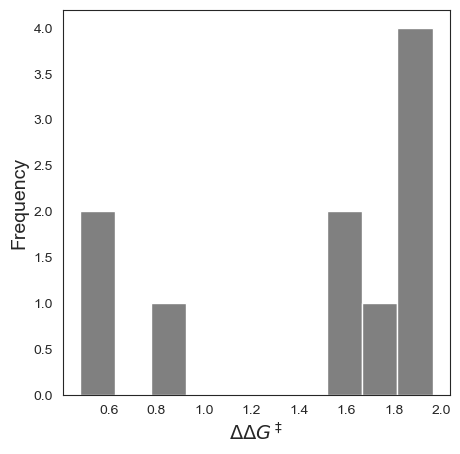

$\Delta\Delta G^\ddagger$  HOMO_Boltz  HOMO_min  HOMO_max  HOMO_range  HOMO_low_E  LUMO_Boltz  LUMO_min  LUMO_max  LUMO_range  ...  pyramidalization_Gavrish_C2(°)_min  pyramidalization_Gavrish_C2(°)_max  pyramidalization_Gavrish_C2(°)_range  pyramidalization_Gavrish_C2(°)_low_E  pyramidalization_Agranat-Radhakrishnan_C2_Boltz  pyramidalization_Agranat-Radhakrishnan_C2_Boltz_stdev  pyramidalization_Agranat-Radhakrishnan_C2_min  pyramidalization_Agranat-Radhakrishnan_C2_max  pyramidalization_Agranat-Radhakrishnan_C2_range  pyramidalization_Agranat-Radhakrishnan_C2_low_E
Compound_Name                                                                                                                                 ...                                                                                                                                                                                                                                                                                                                                                                                                                                                            
N1                              1.963997   -0.298202  -0.30183  -0.29767     0.00416    -0.29767   -0.021914  -0.02551  -0.02143     0.00408  ...                            5.284139                            6.001320                              0.717181                              5.343619                                         0.738237                                           0.008179                                           0.732105                                       0.809091                                         0.076986                                         0.738321
N11                             1.851726   -0.316057  -0.31906  -0.31494     0.00412    -0.31497   -0.040039  -0.04381  -0.03862     0.00519  ...                            5.267987                            6.031974                              0.763987                              5.388399                                         0.740887                                           0.008331                                           0.730396                                       0.812120                                         0.081725                                         0.743354
N14                             1.639875   -0.269394  -0.27223  -0.26591     0.00632    -0.26793   -0.037560  -0.04094  -0.03198     0.00896  ...                            5.255120                            5.478417                              0.223296                              5.337280                                         0.737656                                           0.009514                                           0.728924                                       0.753039                                         0.024115                                         0.737681
N15                             1.550118   -0.291218  -0.29328  -0.28885     0.00443    -0.29328   -0.019058  -0.02110  -0.01693     0.00417  ...                            5.261866                            5.999017                              0.737151                              5.274708                                         0.736151                                           0.014945                                           0.729671                                       0.808850                                         0.079179                                         0.731067
N2                              1.743519   -0.297610  -0.30129  -0.29684     0.00445    -0.29686   -0.021389  -0.02515  -0.02060     0.00455  ...                            5.266027                            6.005822                              0.739795                              5.344095                                         0.737431                                           0.005222                                           0.730138                               

In [67]:
# This cell assumes that your spreadsheets are in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# parameters_header_rows and parameters_start_col variables.
# Check cell outputs to make sure everything looks good

input_folder = "./InputData/" # Folder where the input data is stored
output_folder = "./OutputData/" # Folder where the output data will be stored

parameters_file = "cat_mechanism_neutral" # Excel file to pull parameters from
parameters_sheet = "Sheet1" # Sheet in the Excel file to pull parameters from
parameters_start_col = 12   # 0-indexed column number where the parameters start
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "cat_mechanism_neutral" # Excel file to pull responses from
response_sheet = "Sheet1" # Sheet in the Excel file to pull responses from
response_col = 11 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the substrate labels are
response_header_rows = 0 # Number of rows to skip when reading the responses

RESPONSE_LABEL =  r'$\Delta\Delta G^\ddagger$' # Name of your response variable #'yield (%)'

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel(input_folder + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              )
response_df = pd.read_excel(input_folder + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.rename(columns = {data_df.columns.values[0]: RESPONSE_LABEL}, inplace = True) # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # Remove any rows with blanks

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Get a list of all the features
all_features = list(data_df.columns)
all_features.remove(RESPONSE_LABEL)

# Check for duplicate reaction labels or column names
error = False
if len(list(data_df.index)) != len(list(set(data_df.index))):
    print('THERE ARE DUPLICATE REACTION LABELS IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True
if len(list(data_df.columns)) != len(list(set(data_df.columns))):
    print('THERE ARE DUPLICATE COLUMN NAMES IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True

if not error:
    # Print out the data distribution of the response variable
    plt.figure(figsize=(5, 5))
    plt.hist(data_df[RESPONSE_LABEL], color='grey')
    plt.xlabel(RESPONSE_LABEL, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

    # Display the dataframe
    display(data_df)

# Basic visualization

## Histograms and univariate correlations

['HOMO_Boltz', 'HOMO_min', 'HOMO_max', 'HOMO_range', 'HOMO_low_E', 'LUMO_Boltz', 'LUMO_min', 'LUMO_max', 'LUMO_range', 'LUMO_low_E', 'μ_Boltz', 'μ_min', 'μ_max', 'μ_range', 'μ_low_E', 'η_Boltz', 'η_min', 'η_max', 'η_range', 'η_low_E', 'ω_Boltz', 'ω_Boltz_stdev', 'ω_min', 'ω_max', 'ω_range', 'ω_low_E', 'polar_iso(Debye)_Boltz', 'polar_iso(Debye)_Boltz_stdev', 'polar_iso(Debye)_min', 'polar_iso(Debye)_max', 'polar_iso(Debye)_range', 'polar_iso(Debye)_low_E', 'polar_aniso(Debye)_Boltz', 'polar_aniso(Debye)_Boltz_stdev', 'polar_aniso(Debye)_min', 'polar_aniso(Debye)_max', 'polar_aniso(Debye)_range', 'polar_aniso(Debye)_low_E', 'dipole(Debye)_Boltz', 'dipole(Debye)_Boltz_stdev', 'dipole(Debye)_min', 'dipole(Debye)_max', 'dipole(Debye)_range', 'dipole(Debye)_low_E', 'volume(Bohr_radius³/mol)_Boltz', 'volume(Bohr_radius³/mol)_Boltz_stdev', 'volume(Bohr_radius³/mol)_min', 'volume(Bohr_radius³/mol)_max', 'volume(Bohr_radius³/mol)_range', 'volume(Bohr_radius³/mol)_low_E', 'SASA_surface_area(Å²)_

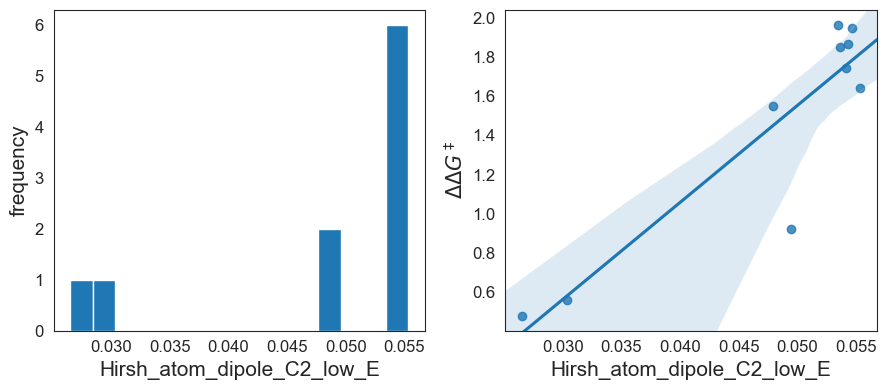

R^2 = 0.82; p-value = 2.81E-04

-------------------------------------------------------------------------------

Hirsh_charge_C3_Boltz
R^2 below cutoff. Skipping.
Hirsh_charge_C3_Boltz_stdev
R^2 below cutoff. Skipping.
Hirsh_charge_C3_min
R^2 below cutoff. Skipping.
Hirsh_charge_C3_max
R^2 below cutoff. Skipping.
Hirsh_charge_C3_range
R^2 below cutoff. Skipping.
Hirsh_charge_C3_low_E
R^2 below cutoff. Skipping.
Hirsh_CM5_charge_C3_Boltz
R^2 below cutoff. Skipping.
Hirsh_CM5_charge_C3_Boltz_stdev
R^2 below cutoff. Skipping.
Hirsh_CM5_charge_C3_min
R^2 below cutoff. Skipping.
Hirsh_CM5_charge_C3_max
R^2 below cutoff. Skipping.
Hirsh_CM5_charge_C3_range
R^2 below cutoff. Skipping.
Hirsh_CM5_charge_C3_low_E
R^2 below cutoff. Skipping.
Hirsh_atom_dipole_C3_Boltz
R^2 below cutoff. Skipping.
Hirsh_atom_dipole_C3_Boltz_stdev
R^2 below cutoff. Skipping.
Hirsh_atom_dipole_C3_min
R^2 below cutoff. Skipping.
Hirsh_atom_dipole_C3_max
R^2 below cutoff. Skipping.
Hirsh_atom_dipole_C3_range
R^2 below 

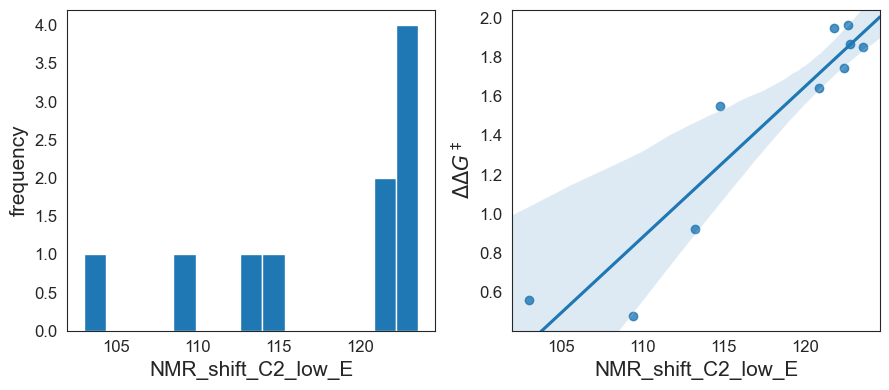

R^2 = 0.88; p-value = 6.44E-05

-------------------------------------------------------------------------------

NMR_shift_C3_Boltz
R^2 below cutoff. Skipping.
NMR_shift_C3_Boltz_stdev
R^2 below cutoff. Skipping.
NMR_shift_C3_min
R^2 below cutoff. Skipping.
NMR_shift_C3_max
R^2 below cutoff. Skipping.
NMR_shift_C3_range
R^2 below cutoff. Skipping.
NMR_shift_C3_low_E
R^2 below cutoff. Skipping.
NMR_shift_O1_Boltz
R^2 below cutoff. Skipping.
NMR_shift_O1_Boltz_stdev
R^2 below cutoff. Skipping.
NMR_shift_O1_min
R^2 below cutoff. Skipping.
NMR_shift_O1_max
R^2 below cutoff. Skipping.
NMR_shift_O1_range
R^2 below cutoff. Skipping.
NMR_shift_O1_low_E
R^2 below cutoff. Skipping.
distance_C1_N1(Å)_Boltz
R^2 below cutoff. Skipping.
distance_C1_N1(Å)_Boltz_stdev
R^2 below cutoff. Skipping.
distance_C1_N1(Å)_min
R^2 below cutoff. Skipping.
distance_C1_N1(Å)_max
R^2 below cutoff. Skipping.
distance_C1_N1(Å)_range
R^2 below cutoff. Skipping.
distance_C1_N1(Å)_low_E
R^2 below cutoff. Skipping.
dista

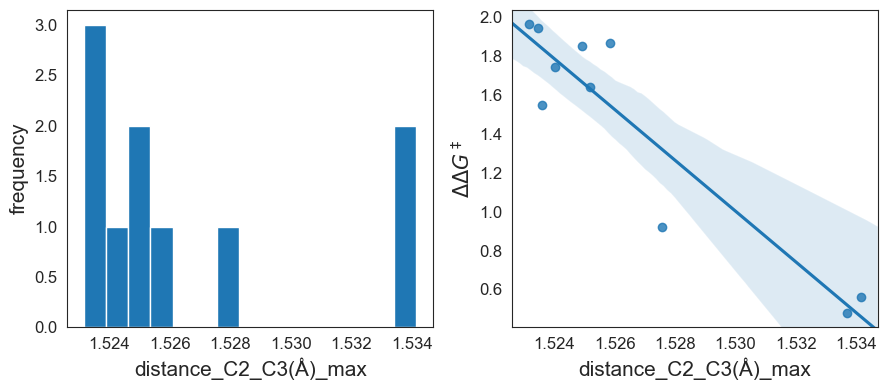

R^2 = 0.86; p-value = 9.83E-05

-------------------------------------------------------------------------------

distance_C2_C3(Å)_range
R^2 below cutoff. Skipping.
distance_C2_C3(Å)_low_E
R^2 below cutoff. Skipping.
distance_C3_O1(Å)_Boltz
R^2 below cutoff. Skipping.
distance_C3_O1(Å)_Boltz_stdev
R^2 below cutoff. Skipping.
distance_C3_O1(Å)_min
R^2 below cutoff. Skipping.
distance_C3_O1(Å)_max
R^2 below cutoff. Skipping.
distance_C3_O1(Å)_range
R^2 below cutoff. Skipping.
distance_C3_O1(Å)_low_E
R^2 below cutoff. Skipping.
angle_C1_N1_C2(°)_Boltz
R^2 below cutoff. Skipping.
angle_C1_N1_C2(°)_Boltz_stdev
R^2 below cutoff. Skipping.
angle_C1_N1_C2(°)_min
R^2 below cutoff. Skipping.
angle_C1_N1_C2(°)_max
R^2 below cutoff. Skipping.
angle_C1_N1_C2(°)_range
R^2 below cutoff. Skipping.
angle_C1_N1_C2(°)_low_E
R^2 below cutoff. Skipping.
angle_N1_C2_C3(°)_Boltz
R^2 below cutoff. Skipping.
angle_N1_C2_C3(°)_Boltz_stdev
R^2 below cutoff. Skipping.
angle_N1_C2_C3(°)_min
R^2 below cutoff. Skipp

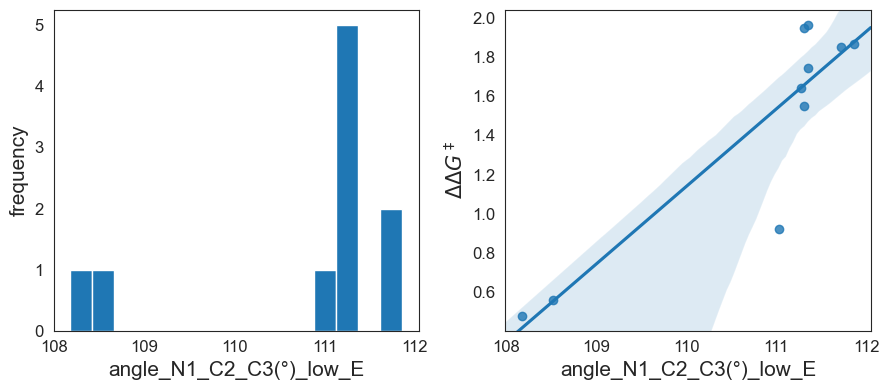

R^2 = 0.81; p-value = 4.24E-04

-------------------------------------------------------------------------------

angle_C2_C3_O1(°)_Boltz
R^2 below cutoff. Skipping.
angle_C2_C3_O1(°)_Boltz_stdev
R^2 below cutoff. Skipping.
angle_C2_C3_O1(°)_min
R^2 below cutoff. Skipping.
angle_C2_C3_O1(°)_max
R^2 below cutoff. Skipping.
angle_C2_C3_O1(°)_range
R^2 below cutoff. Skipping.
angle_C2_C3_O1(°)_low_E
R^2 below cutoff. Skipping.
dihedral_C1_N1_C2_C3(°)_Boltz
R^2 below cutoff. Skipping.
dihedral_C1_N1_C2_C3(°)_Boltz_stdev
R^2 below cutoff. Skipping.
dihedral_C1_N1_C2_C3(°)_min
R^2 below cutoff. Skipping.
dihedral_C1_N1_C2_C3(°)_max
R^2 below cutoff. Skipping.
dihedral_C1_N1_C2_C3(°)_range
R^2 below cutoff. Skipping.
dihedral_C1_N1_C2_C3(°)_low_E
R^2 below cutoff. Skipping.
%Vbur_C1_2.0Å_Boltz
R^2 below cutoff. Skipping.
%Vbur_C1_2.0Å_Boltz_stdev
R^2 below cutoff. Skipping.
%Vbur_C1_2.0Å_min
R^2 below cutoff. Skipping.
%Vbur_C1_2.0Å_max
R^2 below cutoff. Skipping.
%Vbur_C1_2.0Å_range
R^2 below

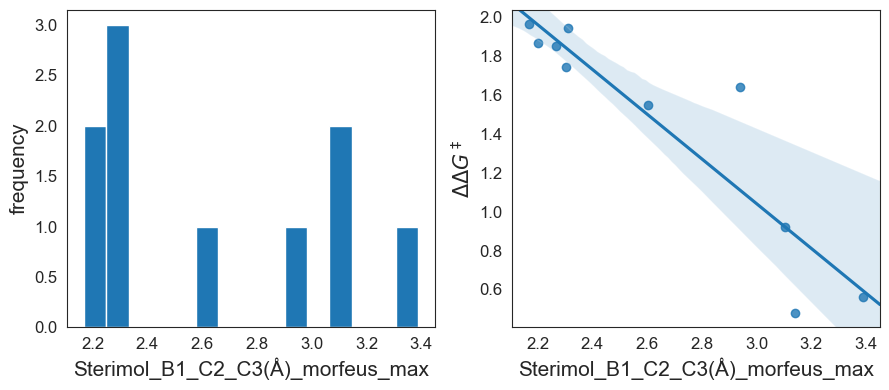

R^2 = 0.84; p-value = 1.87E-04

-------------------------------------------------------------------------------

Sterimol_B1_C2_C3(Å)_morfeus_range
R^2 below cutoff. Skipping.
Sterimol_B1_C2_C3(Å)_morfeus_low_E
R^2 below cutoff. Skipping.
Sterimol_B5_C2_C3(Å)_morfeus_Boltz
R^2 below cutoff. Skipping.
Sterimol_B5_C2_C3(Å)_morfeus_Boltz_stdev
R^2 below cutoff. Skipping.
Sterimol_B5_C2_C3(Å)_morfeus_min
R^2 below cutoff. Skipping.
Sterimol_B5_C2_C3(Å)_morfeus_max
R^2 below cutoff. Skipping.
Sterimol_B5_C2_C3(Å)_morfeus_range
R^2 below cutoff. Skipping.
Sterimol_B5_C2_C3(Å)_morfeus_low_E
R^2 below cutoff. Skipping.
Buried_Sterimol_L_N1_C1_5.0(Å)_Boltz
R^2 below cutoff. Skipping.
Buried_Sterimol_L_N1_C1_5.0(Å)_Boltz_stdev
R^2 below cutoff. Skipping.
Buried_Sterimol_L_N1_C1_5.0(Å)_min
R^2 below cutoff. Skipping.
Buried_Sterimol_L_N1_C1_5.0(Å)_max
R^2 below cutoff. Skipping.
Buried_Sterimol_L_N1_C1_5.0(Å)_range
R^2 below cutoff. Skipping.
Buried_Sterimol_L_N1_C1_5.0(Å)_low_E
R^2 below cutoff.

In [69]:
# {features} should be a list of feature names or column numbers you want to get the distribution and correlation for
features = all_features # Cycles through all features
# features = list(range(4,16)) + [27, 32] # Cycles through a specific set of features by column number
#features = ['NBO_charge_C3_min'] # Cycles through a specific set of features by name

r2_cutoff = 0.8 # R^2 cutoff for correlation below which the feature will be skipped

# This feels like a relic of a bygone era, but here it is. 'matplotlib' refers to what was once the 'OG' cell.
visualization_type = 'seaborn' # 'matplotlib' or 'seaborn'

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Convert all features to column names
features = mlr_utils.process_features(features, data_df)
print(features)

anything = False
for feature in features:
    print(feature)

    # If the feature has no variance it would break the math later on, so we skip it
    if data_df[feature].std() == 0:
        print("No variance in feature. Skipping.")
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature], data_df[RESPONSE_LABEL])
    fit_line = intercept+slope*data_df[feature]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        continue

    plt.figure(figsize=(9, 4))
    
    # Plot feature distribution
    plt.subplot(1,2,1)
    plt.hist(data_df[feature], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot univariate correlation
    plt.subplot(1,2,2)

    if visualization_type == 'matplotlib':
        plt.scatter(data_df[feature], data_df[RESPONSE_LABEL],color="black",marker="s",alpha=0.5)    
        plt.plot(data_df[feature],fit_line,color="black")
    elif visualization_type == 'seaborn':
        sns.set_style("white")
        sns.regplot(x=data_df[feature],y=data_df[RESPONSE_LABEL],ci=95,truncate=False)
        x_max=np.max(data_df[feature])
        x_min=np.min(data_df[feature])
        y_max=np.max(data_df[RESPONSE_LABEL])
        y_min=np.min(data_df[RESPONSE_LABEL])
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
    else:
        print(f'Invalid visualization type: {visualization_type}. Please fix and try again.')
        break

    plt.xlabel(f'{feature}',fontsize=15)
    plt.ylabel(RESPONSE_LABEL,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    plt.tight_layout()
    plt.show()  
    anything = True  

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n") 

if anything:
    print('At least one result!') 
else:
    print('No results!') 

## Plot a feature vs. another feature

Hirsh_atom_dipole_N1_Boltz - HOMO_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - HOMO_min
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - HOMO_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - HOMO_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - HOMO_low_E
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - LUMO_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - LUMO_min
R^2 below cutoff. Skipping.

-------------------------------------

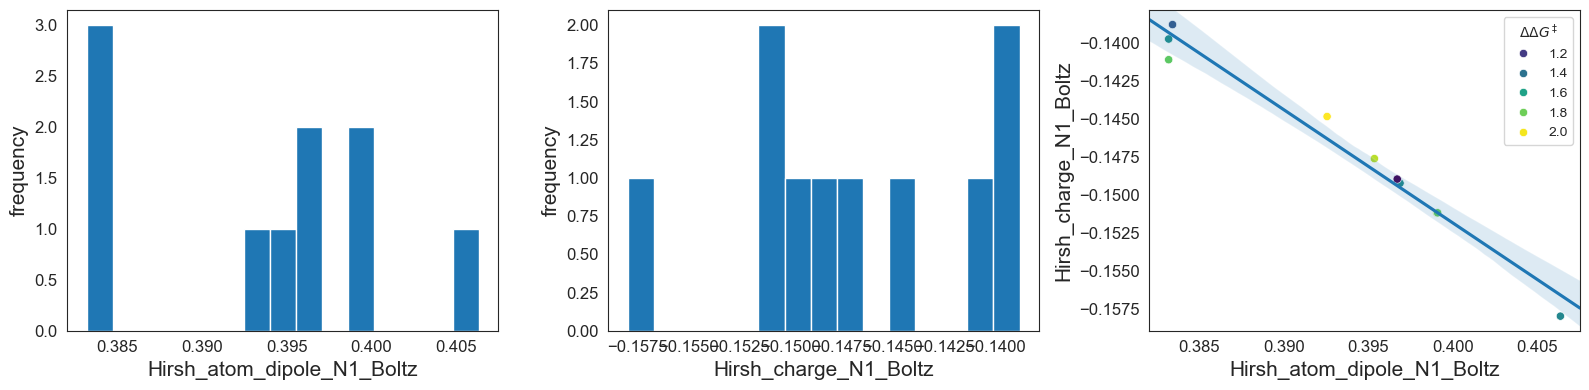


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_N1_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_N1_min
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_N1_max
R^2 = 0.82; p-value = 2.80E-04


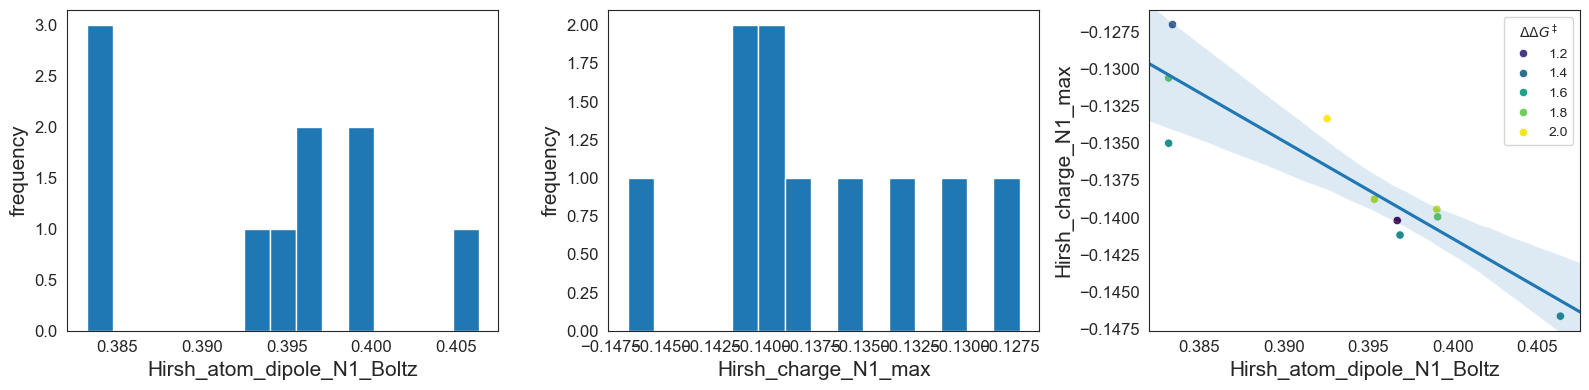


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_N1_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_N1_low_E
R^2 = 0.87; p-value = 9.05E-05


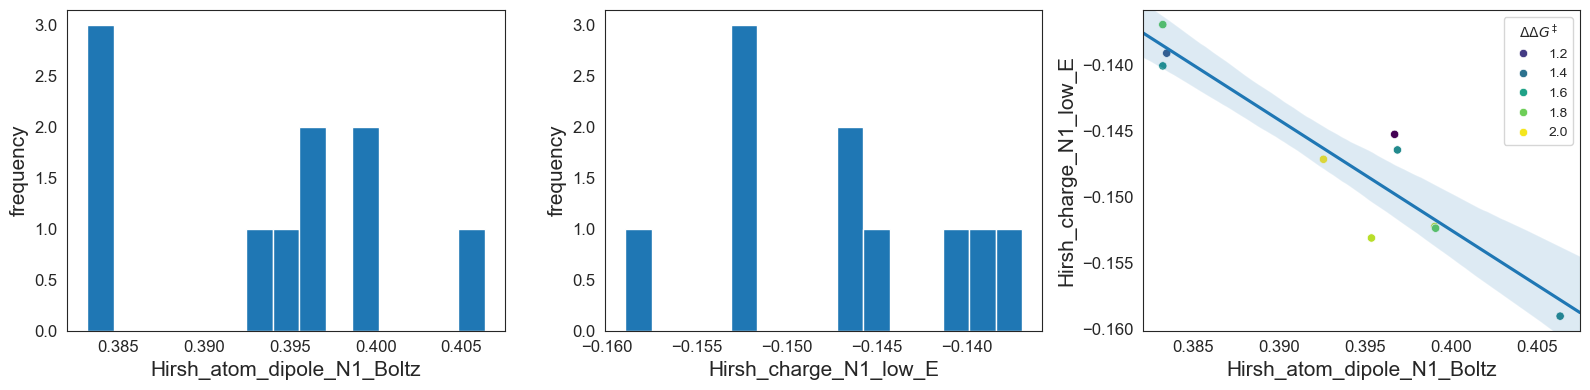


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_CM5_charge_N1_Boltz
R^2 = 0.89; p-value = 3.51E-05


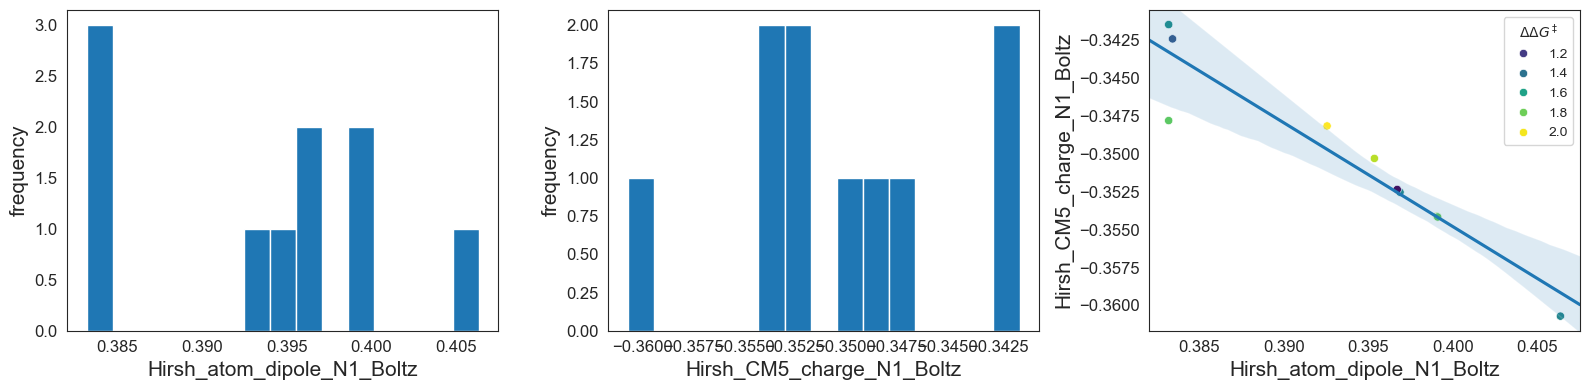


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_CM5_charge_N1_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_CM5_charge_N1_min
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_CM5_charge_N1_max
R^2 = 0.75; p-value = 1.17E-03


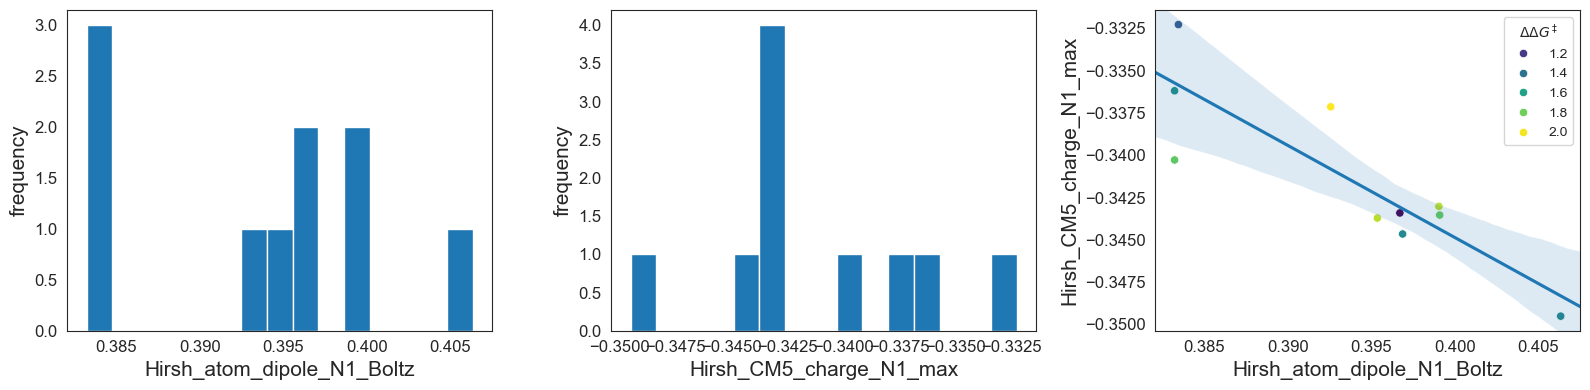


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_CM5_charge_N1_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_CM5_charge_N1_low_E
R^2 = 0.86; p-value = 1.26E-04


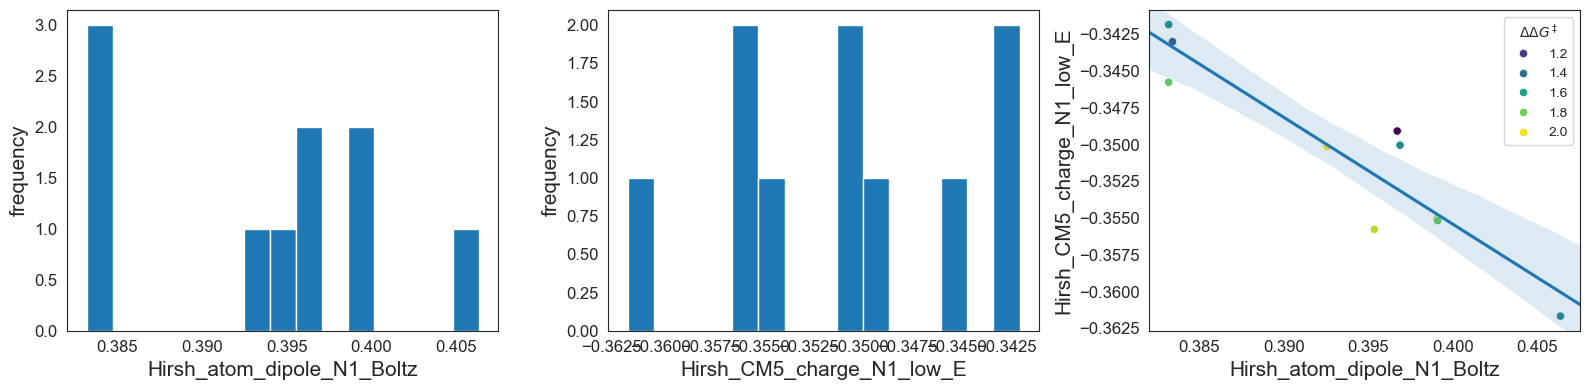


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_atom_dipole_N1_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_atom_dipole_N1_min
R^2 = 0.83; p-value = 2.43E-04


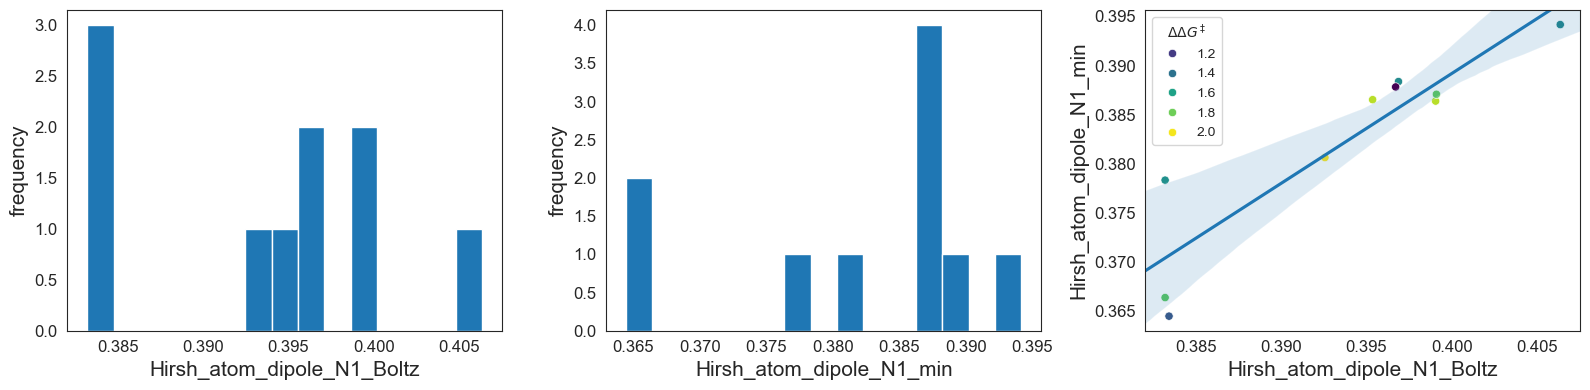


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_atom_dipole_N1_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_atom_dipole_N1_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_atom_dipole_N1_low_E
R^2 = 0.84; p-value = 2.05E-04


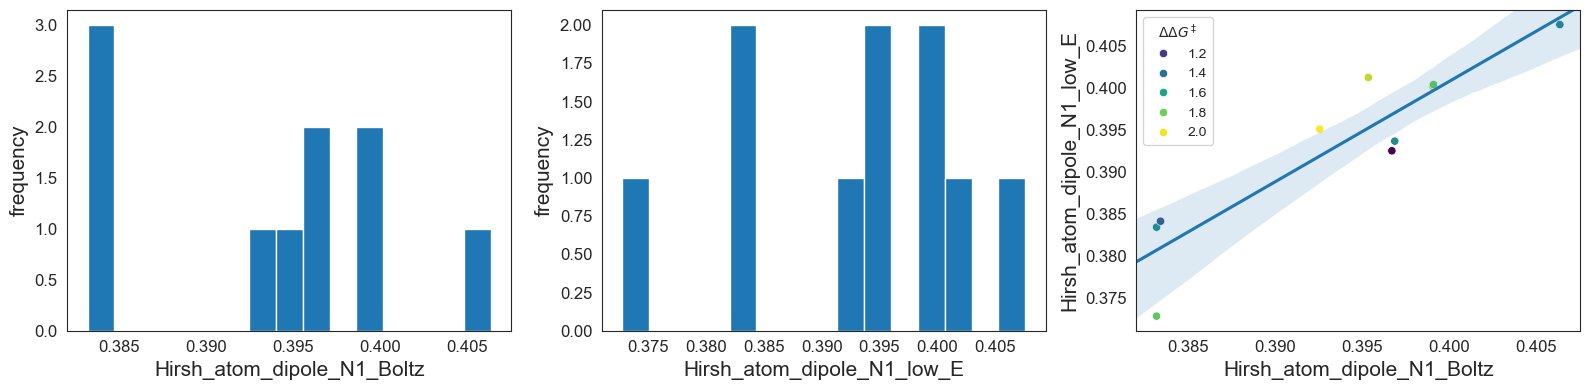


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_C2_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_C2_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_C2_min
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_C2_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_C2_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Hirsh_charge_C2_low_E
R^2 below cutoff. Skipping.

-------------------------------

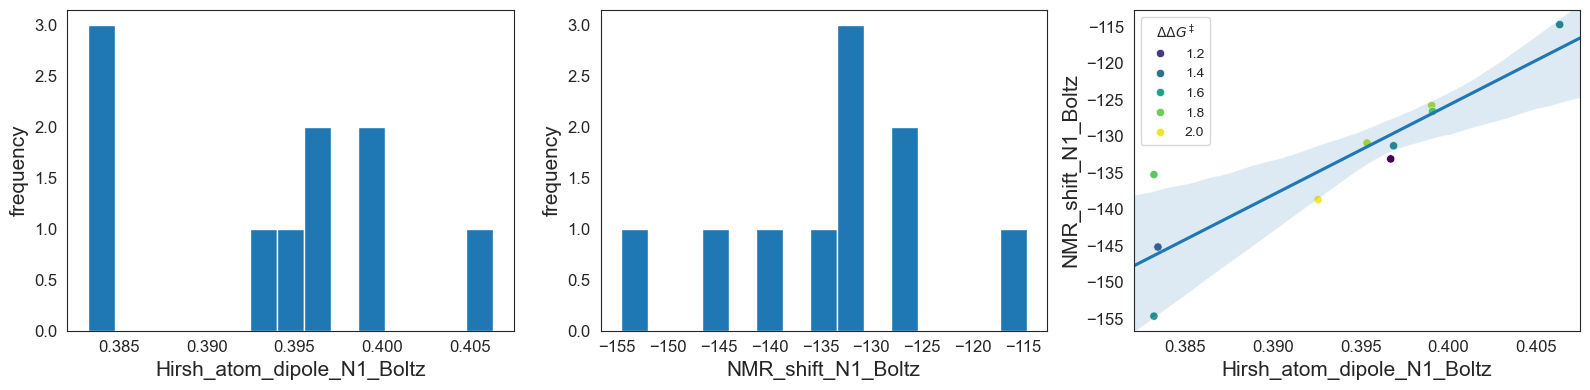


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_N1_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_N1_min
R^2 = 0.77; p-value = 8.90E-04


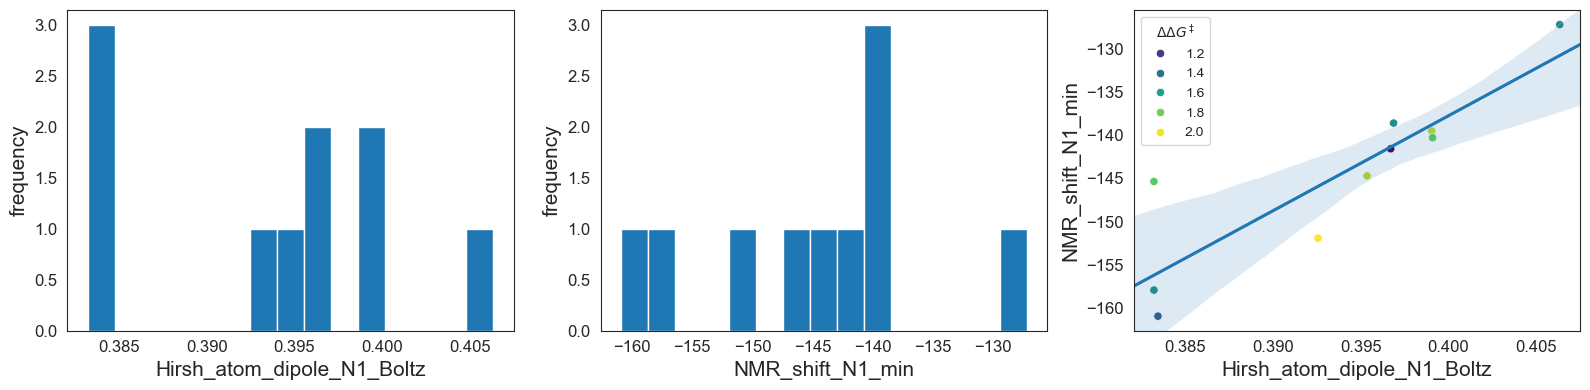


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_N1_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_N1_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_N1_low_E
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C2_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C2_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C2_min
R^2 below cutoff. Skipping.

-------------------------------------------------

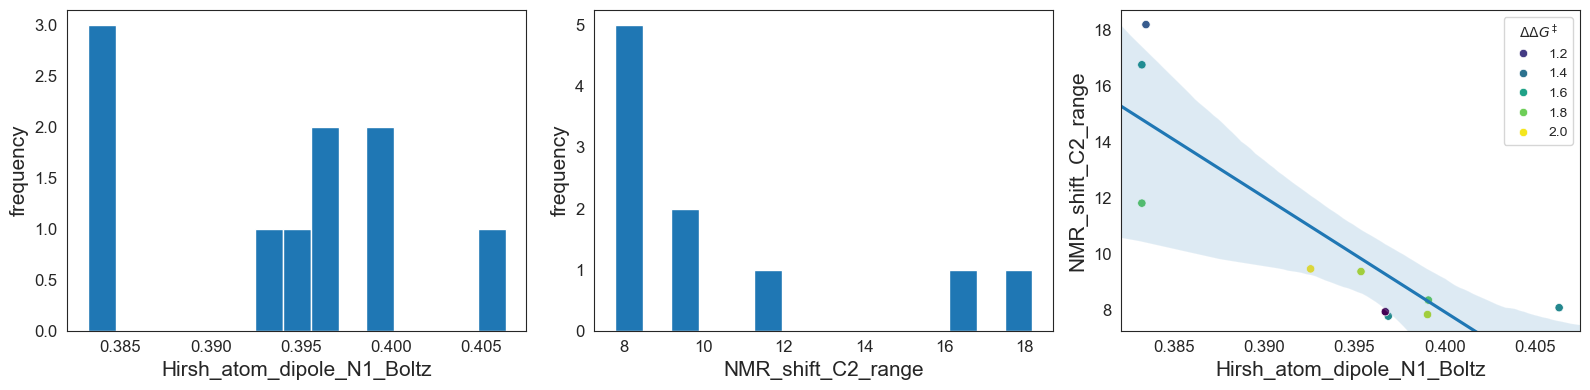


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C2_low_E
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C3_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C3_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C3_min
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C3_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - NMR_shift_C3_range
R^2 below cutoff. Skipping.

-------------------------------------------------

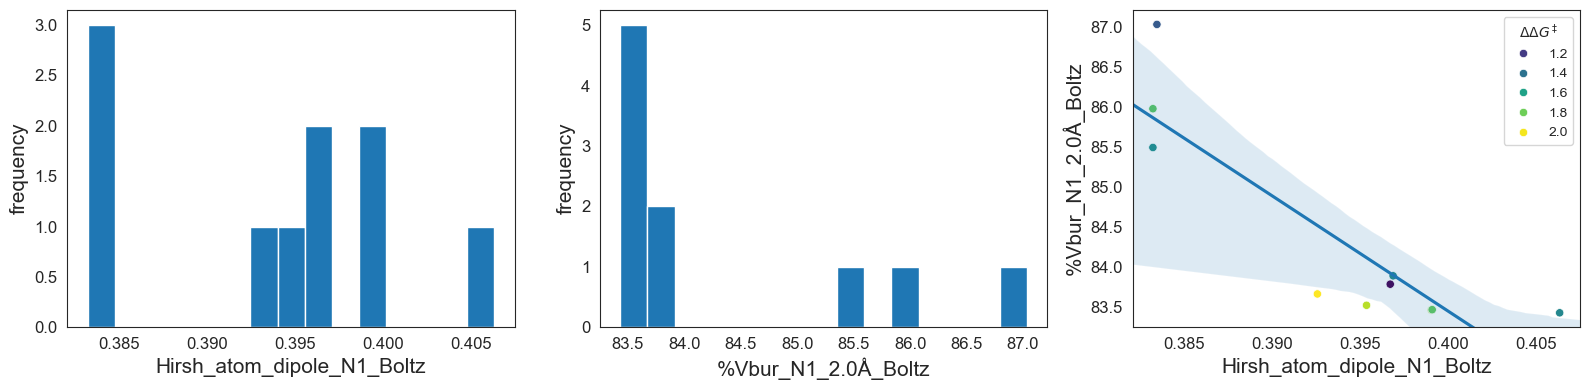


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_2.0Å_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_2.0Å_min
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_2.0Å_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_2.0Å_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_2.0Å_low_E
R^2 = 0.71; p-value = 2.19E-03


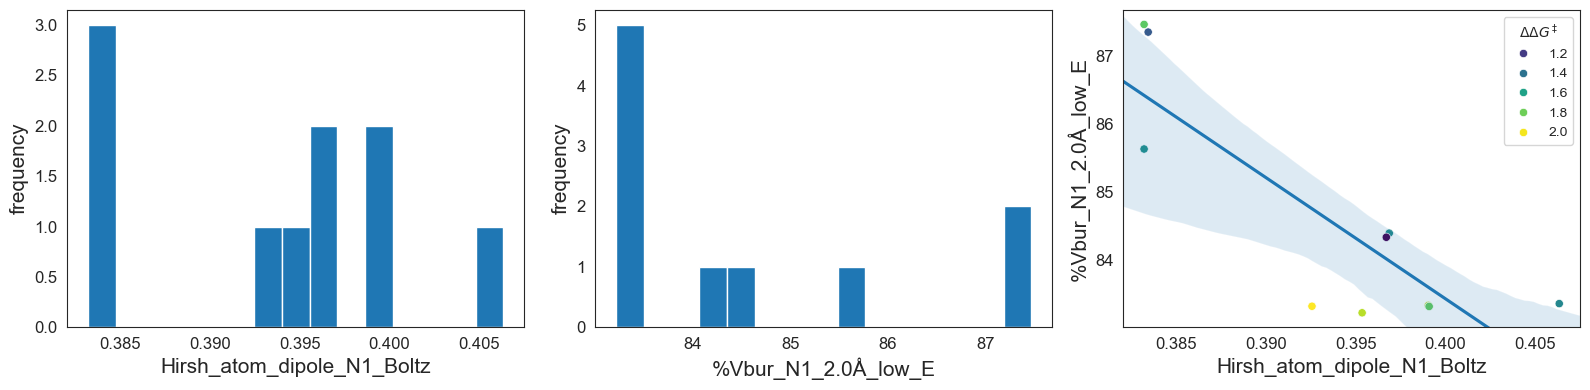


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C2_2.0Å_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C2_2.0Å_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C2_2.0Å_min
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C2_2.0Å_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C2_2.0Å_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C2_2.0Å_low_E
R^2 below cutoff. Skipping.

-------------------------------------------

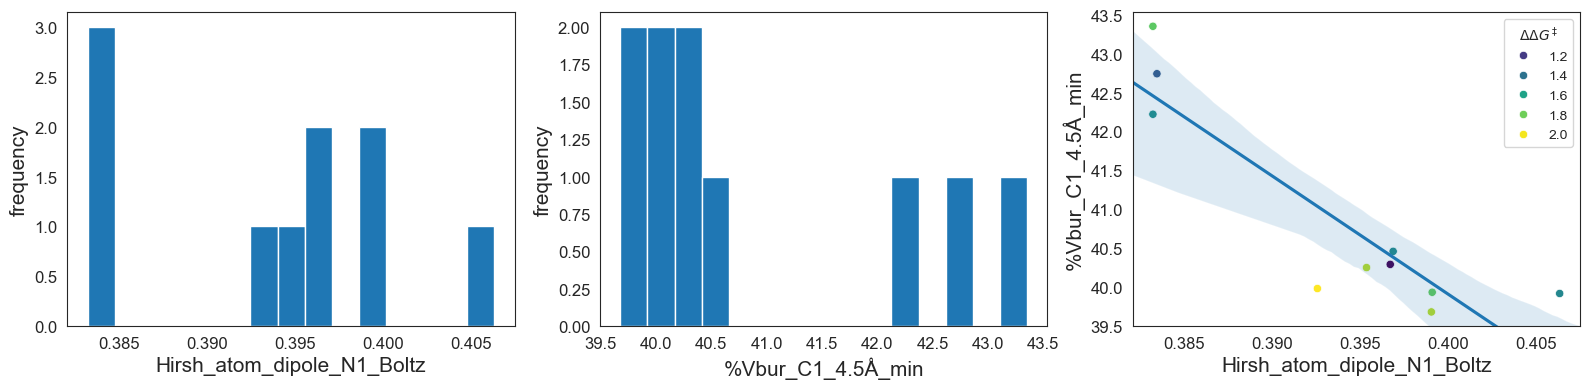


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C1_4.5Å_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C1_4.5Å_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C1_4.5Å_low_E
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_4.5Å_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_4.5Å_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_4.5Å_min
R^2 below cutoff. Skipping.

-------------------------------------------

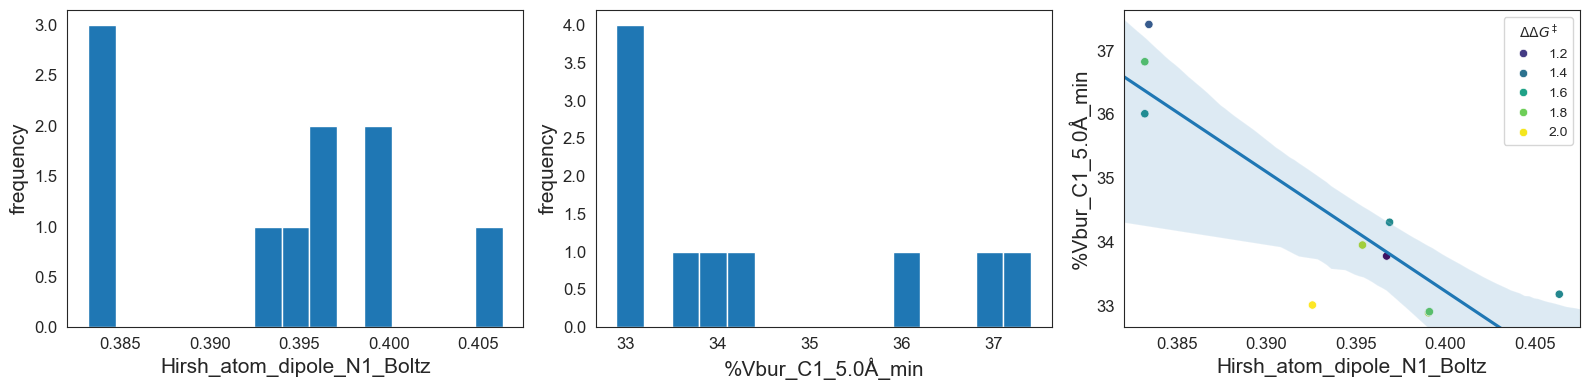


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C1_5.0Å_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C1_5.0Å_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_C1_5.0Å_low_E
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_5.0Å_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_5.0Å_Boltz_stdev
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - %Vbur_N1_5.0Å_min
R^2 below cutoff. Skipping.

-------------------------------------------

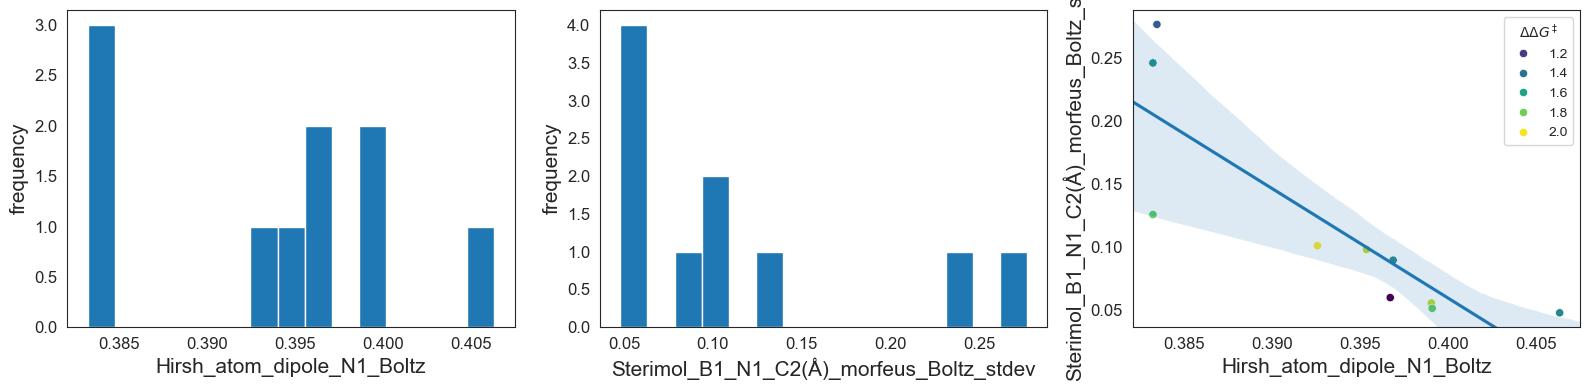


-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Sterimol_B1_N1_C2(Å)_morfeus_min
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Sterimol_B1_N1_C2(Å)_morfeus_max
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Sterimol_B1_N1_C2(Å)_morfeus_range
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Sterimol_B1_N1_C2(Å)_morfeus_low_E
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Sterimol_B5_N1_C2(Å)_morfeus_Boltz
R^2 below cutoff. Skipping.

-------------------------------------------------------------------------------

Hirsh_atom_dipole_N1_Boltz - Sterimol_B5_N1_C2(Å)_mo

In [14]:
# {features_1} and {features_2} are the features you want to get the correlation for
# Set them to all_features to get the correlation for all features, or specify a list of features by name or column number to compare

features_1 = ['Hirsh_atom_dipole_N1_Boltz']
features_2 = all_features

# features_1 = list(range(4,16)) + [27, 32] # Cycles through a specific set of features by column number
# features_2 = ['vbur_vbur_min', 'vmin_vmin_boltz'] # Cycles through a specific set of features by name

r2_cutoff = 0.7 # R^2 cutoff for correlation below which the feature pair will be skipped

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Convert all features to column names
features_1 = mlr_utils.process_features(features_1, data_df)
features_2 = mlr_utils.process_features(features_2, data_df)

for feature_1,feature_2 in itertools.product(features_1, features_2):
    # No use wasting time comparing a feature to itself
    if feature_1 == feature_2:
        continue

    print(f'{feature_1} - {feature_2}')

    # If either feature has no variance it would break the math later on, so we skip it
    if data_df[feature_1].std() == 0 or data_df[feature_2].std() == 0:
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature_1], data_df[feature_2])
    fit_line = intercept+slope*data_df[feature_1]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        print("\n-------------------------------------------------------------------------------\n")
        continue
    
    # Print p-values and R^2 values
    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

    plt.figure(figsize=(16, 4))

    # Plot feature 1 distribution
    plt.subplot(1,3,1)
    plt.hist(data_df[feature_1], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(feature_1,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot feature 2 distribution
    plt.subplot(1,3,2)
    plt.hist(data_df[feature_2], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(feature_2,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot bivariate correlation
    plt.subplot(1,3,3)
    sns.set_style("white")
    sns.scatterplot(x=data_df[feature_1], y=data_df[feature_2], hue=data_df[RESPONSE_LABEL], palette="viridis")
    sns.regplot(x=data_df[feature_1],y=data_df[feature_2],scatter=False,truncate=False)

    x_max=np.max(data_df[feature_1])
    x_min=np.min(data_df[feature_1])
    y_max=np.max(data_df[feature_2])
    y_min=np.min(data_df[feature_2])
    delta_x = 0.05 * (x_max-x_min)
    delta_y = 0.05 * (y_max-y_min)
    plt.xlim([x_min-delta_x,x_max+delta_x])
    plt.ylim([y_min-delta_y,y_max+delta_y])

    plt.xlabel(feature_1,fontsize=15)
    plt.ylabel(feature_2,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    # Show the plots
    plt.tight_layout()
    plt.show()
    print("\n-------------------------------------------------------------------------------\n")
    

## Correlation Map

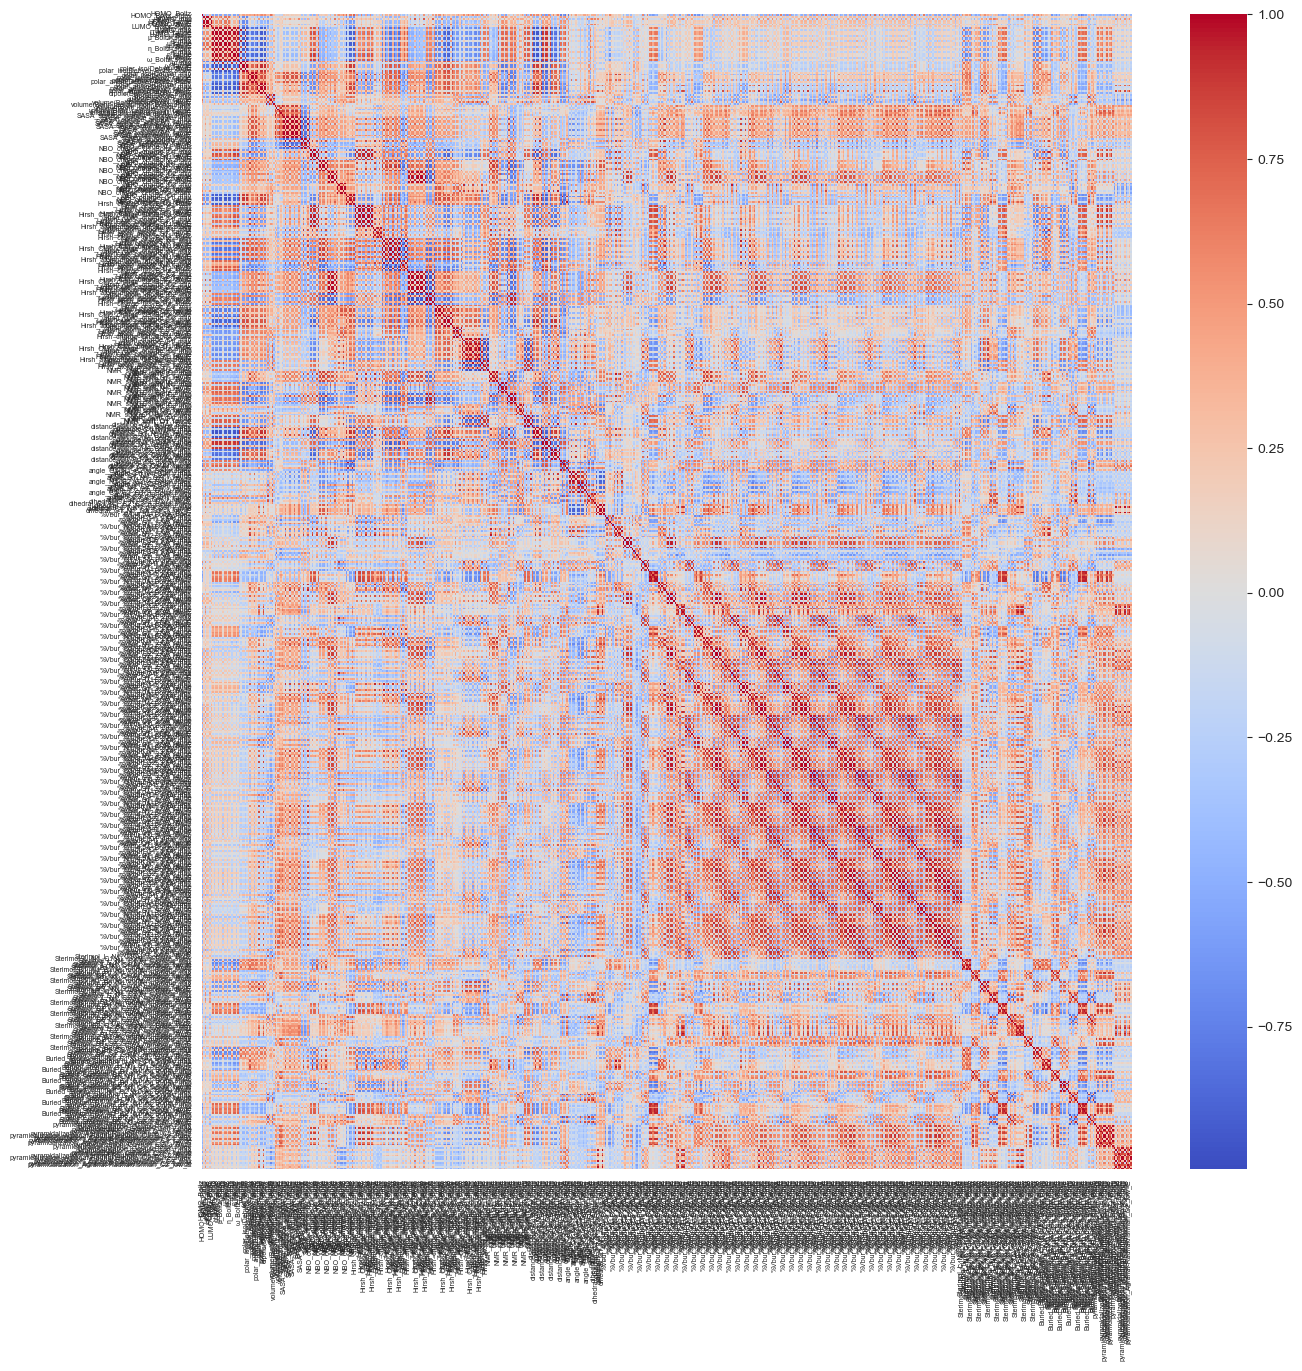

In [7]:
# Run to see how correlated the features are with each other

corrmap = data_df.corr()

plt.subplots(figsize=(15,15))
sns.heatmap(corrmap,center=0, annot=False, cmap="coolwarm", cbar=True) #linewidths=0.5
plt.xticks(range(len(all_features)),all_features, fontsize=5, rotation=90)
plt.yticks(range(len(all_features)),all_features, fontsize=5)
plt.show()

# Threshold Analysis

## Train/Validation/Test split

Training Set: ['N1', 'N11', 'N14', 'N15', 'N2', 'N3', 'N4', 'N5', 'N6', 'N9']
Validation Set: []

Training Set size: 10
Validation Set size: 0

Training Set mean: 1.556
Validation Set mean: nan


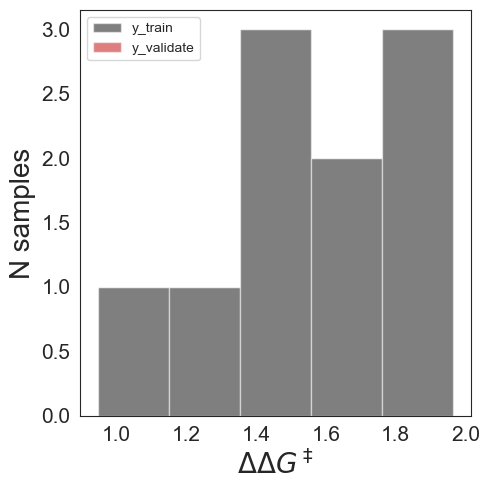

In [53]:
# Split options are 'random', 'ks', 'y_equidistant', 'stratified', 'define', 'none'

# Core options
split = "none"
validation_ratio = 0.1

# Test set options
use_test = False
test_ratio = 0.2

# Less common parameters
stratified_quantiles = 8 # Number of quantiles to split the data into for stratified sampling
defined_training_set = [] # If you want to manually define the training set, put the list of points here
defined_validation_set = [] # If you want to manually define the validation set, put the list of points here
defined_test_set = [] # If you want to manually define the test set, put the list of points here
randomstate = 42 # Random state for reproducibility

# If you get 'ValueError: The least populated class in y has only 1 member...', decrease the number of stratified_quantiles

# --------------------------------------------------------------------------------------------------------------

training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, validation_ratio, test_ratio, all_features, RESPONSE_LABEL, use_test,
                                                        defined_test_set=defined_test_set, defined_training_set=defined_training_set, defined_validation_set=defined_validation_set,
                                                        randomstate=randomstate, stratified_quantiles=stratified_quantiles)

# For bookeeping purposes
if split == 'none':
    validation_ratio = 0
    test_ratio = 0

## Automatic Threshold Analysis

In [ ]:
# Cutoff in your output for what counts as an active ligand
y_cut = 10

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands over inactive ligands (default 1 and 1)
# If you want to prioritize correctly identifying active ligands, increase active_weight
# If you want to prioritize correctly identifying inactive ligands, increase inactive_weight
# This is only used if evaluation_method is set to 'weighted_accuracy' or 'weighted_f1'
active_weight = 1
inactive_weight = 1

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# How many threshold dimensions do you want?
n_thresholds = 2

# What percentage of thresholds are analyzed in each subsequent step
percentage = 100

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set class weights from user input
class_weight = {1:active_weight, 0:inactive_weight}

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, all_features)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, validation_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with multiprocessing.Pool(processes=int(n_processors-2)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, itertools.repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

## Manual Threshold Analysis

## Visualize Thresholds

In [ ]:
# For more direct control over plot style, changes can be made to the plotting functions in hotsput_utils.py
# One of the above functions must be run before this cell can ran
hotspot_index =  0
print(best_hotspots[hotspot_index])

# subset can be 'all', 'training', or 'test'
# You can change the coloring to either 'scaled' or 'binary'
hotspot_utils.plot_hotspot(best_hotspots[hotspot_index], 
                            subset='all', 
                            coloring='binary', 
                            output_label=RESPONSE_LABEL, 
                            gradient_color='Oranges')

## Threshold Internal Test Prediction

If this isn't the final step of your modeling process then this is just another validation set and not a true test set

In [ ]:
# Select hotspot to test
hotspot_index = 0

# Set to True if you want to see only the test results plotted
hide_training = False

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN hotspot_utils.plot_hotspot(...)
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]
test_df = data_df.loc[test_set]

# Evaluate each validation point on each threshold
threshold_evaluations = hs.expand(test_df)

# Print the hotspot stats
hs.print_stats()

# Get validation stats and display the hotspot
print("Internal Test Stats:")
hs.get_external_accuracy(test_df, RESPONSE_LABEL, verbose=True)
hotspot_utils.plot_hotspot(hs, test_df, test_df, coloring='binary', output_label=RESPONSE_LABEL, hide_training=hide_training)

# Display the threshold evaluations
# True means the point is in on the active side of that threshold
display(threshold_evaluations)

# Data preparation: Training/Validation/Test set split, Scaling

## Filter data before train/validation/test split

In [ ]:
# If you want to go forward with only data from the active space of a (multi)threshold, run this cell
# Select which hotspot you want to use based on the index from the Threshold Analysis section

hotspot_index = 0

# --------------------------------------------------------------------------------------------------------------

points_to_keep = best_hotspots[hotspot_index].get_hotspot_space()

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

In [ ]:
# If you want to use a custom cutoff in a certain parameter to limit which points you take forward, run this cell
# Set keep_points_below_cutoff to True if you want to keep points below the cutoff, False if you want to keep points above

cutoff_feature = 'vbur_vbur_min'
cutoff_value = 57.277
keep_points_below_cutoff = True

# --------------------------------------------------------------------------------------------------------------

points_to_keep = data_df.index.to_list()

for i in data_df.index:
    if keep_points_below_cutoff:
        if data_df.loc[i, cutoff_feature] > cutoff_value:
            points_to_keep.remove(i)
    else:
        if data_df.loc[i, cutoff_feature] < cutoff_value:
            points_to_keep.remove(i)

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

In [ ]:
# If you want to exclude specific points from training, validation, and test sets, run this cell
# Points are excluded by their index label

points_to_exclude = ['R1_186']

# --------------------------------------------------------------------------------------------------------------

points_to_keep = [point for point in data_df.index if point not in points_to_exclude]

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

## Train/Validation/Test Set Split

Training Set: ['N11', 'N14', 'N15', 'N2', 'N3', 'N4', 'N5', 'N9']
Validation Set: ['N1', 'N6']

Training Set size: 8
Validation Set size: 2

Training Set mean: 1.500
Validation Set mean: 1.262


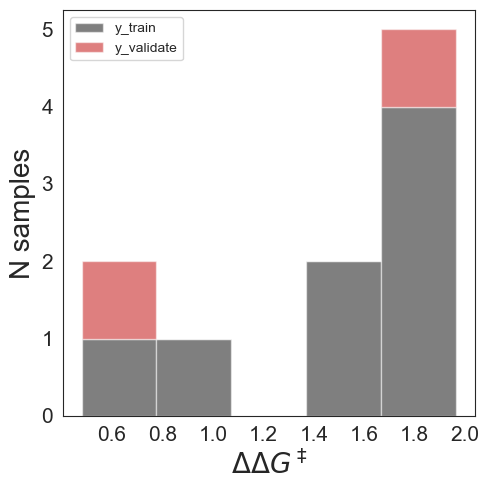

In [76]:
# Split options are 'random', 'ks', 'y_equidistant', 'stratified', 'define', 'none'
# If you want to pull the train, validation, and test sets from only the subset of your data defined above, set use_filtering to True
# Validation r^2 method options are 'out-of-sample' or 'standard'. 'out-of-sample' is recommended for most cases as it computes the variance relative to the training set.

# Core options
split = 'ks'
validation_ratio = 0.2

# Test set options
use_test = False
test_ratio = 0.1

# Some flags
use_filtering = False
use_scaling = True

# Less common parameters
validation_R2_method = 'out-of-sample' # 'out-of-sample' or 'standard', OOS is recommended and what we've normally used
stratified_quantiles = 3 # Number of quantiles to split the data into for stratified sampling
defined_training_set = ['A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A18', 'A2', 'A3', 'A5', 'A9'] # If you want to manually define the training set, put the list of points here
defined_validation_set = ['A4'] # If you want to manually define the validation set, put the list of points here
defined_test_set = ['A19'] # If you want to manually define the test set, put the list of points here
randomstate = 42 # Random state for reproducibility

# --------------------------------------------------------------------------------------------------------------

if use_filtering:
    training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, validation_ratio, test_ratio, all_features, RESPONSE_LABEL, use_test,
                                                            defined_test_set=defined_test_set, defined_training_set=defined_training_set, defined_validation_set=defined_validation_set,
                                                            randomstate=randomstate, stratified_quantiles=stratified_quantiles, subset=points_to_keep)
else:
    training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, validation_ratio, test_ratio, all_features, RESPONSE_LABEL, use_test,
                                                            defined_test_set=defined_test_set, defined_training_set=defined_training_set, defined_validation_set=defined_validation_set,
                                                            randomstate=randomstate, stratified_quantiles=stratified_quantiles)

if use_scaling:
    # Scales the parameters then puts them into modeling_data_df
    scaler = StandardScaler() # If you want to use a different scaler, change this line

    scaler.fit(data_df.loc[training_set, :])
    modeling_data = scaler.transform(data_df)
    modeling_data_df = pd.DataFrame(modeling_data, index = data_df.index, columns = data_df.columns)
    modeling_data_df[RESPONSE_LABEL] = data_df[RESPONSE_LABEL]
else:
    modeling_data_df = data_df

# For bookeeping purposes
if split == 'none':
    validation_ratio = 0
    test_ratio = 0


# Linear modelling - MLR

## Manual Feature Selection

Fold 0:
  Train: index=[ 0  1  2  4  5  6  8  9 10 12 14 15]
  Test:  index=[ 3  7 11 13]
  R^2: 0.6601547217598419
Fold 1:
  Train: index=[ 0  1  2  3  4  6  7  9 10 11 12 13 14]
  Test:  index=[ 5  8 15]
  R^2: 0.8099311187556293
Fold 2:
  Train: index=[ 0  1  3  4  5  6  7  8  9 11 12 13 15]
  Test:  index=[ 2 10 14]
  R^2: 0.2984821811213705
Fold 3:
  Train: index=[ 0  2  3  4  5  7  8  9 10 11 13 14 15]
  Test:  index=[ 1  6 12]
  R^2: -0.8678755875434352
Fold 4:
  Train: index=[ 1  2  3  5  6  7  8 10 11 12 13 14 15]
  Test:  index=[0 4 9]
  R^2: -25.900427856626038
Fold 5:
  Train: index=[ 0  2  4  5  6  7  8  9 10 11 12 13]
  Test:  index=[ 1  3 14 15]
  R^2: 0.3200336045907577
Fold 6:
  Train: index=[ 0  1  3  4  5  7  8  9 10 12 13 14 15]
  Test:  index=[ 2  6 11]
  R^2: -0.07581169603562588
Fold 7:
  Train: index=[ 0  1  2  3  4  6  7 10 11 12 13 14 15]
  Test:  index=[5 8 9]
  R^2: 0.8248488320159504
Fold 8:
  Train: index=[ 1  2  3  4  5  6  7  8  9 11 13 14 15]
  Test:  i

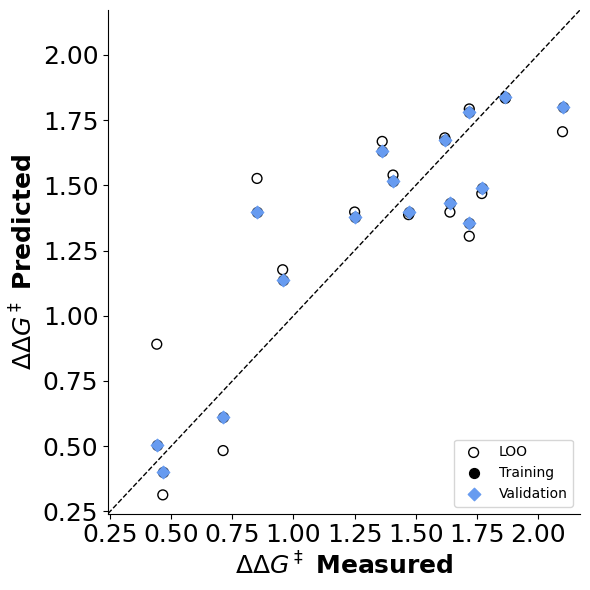

In [28]:
# {features_selected} should be a list of features (names or column numbers) to include in the model

#features_selected = [4, 64, 72]
features_selected = ['NBO_charge_C3_max', '%Vbur_O1_2.5Å_low_E', '%Vbur_C1_2.0Å_min']

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...) BELOW
# --------------------------------------------------------------------------------------------------------------

features_selected = mlr_utils.process_features(features_selected, modeling_data_df)

# Break up the train/validate data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, features_selected] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, features_selected] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

# Set up MLR and predict train/validate
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
try:
    y_predictions_validate =  lr.predict(x_validate)
except ValueError as e:
    print(f'Error: {e}')
    print('This cell is not currently equiped to handle modeling without a validation set.')
    raise mlr_utils.StopExecution

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Set up the results dataframe
columns = ['Model', 'n_terms', 'R^2', 'Q^2', 'MAE', 'RMSE', 'Validation R^2']
results = pd.DataFrame(columns = columns)
results.loc[0] = [tuple(features_selected), len(features_selected), lr.score(x_train, y_train), q2, metrics.mean_absolute_error(y_train, y_predictions_train), np.sqrt(metrics.mean_squared_error(y_train, y_predictions_train)), mlr_utils.get_r2(y_validate,y_predictions_validate,y_train,validation_R2_method)]

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio} (Training: {len(training_set)}, Validation: {len(validation_set)})")
print(f'Used scaling: {use_scaling}')

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(features_selected):
    print(f'{lr.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train, y_predictions_train):.3f}")
print(f'Training RMSE = {np.sqrt(metrics.mean_squared_error(y_train, y_predictions_train)):.3f}')
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nValidation R2      = {mlr_utils.get_r2(y_validate,y_predictions_validate,y_train,validation_R2_method):.3f}")
print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')
print(f'Validation RMSE    = {np.sqrt(metrics.mean_squared_error(y_validate,y_predictions_validate)):.3f}')

# Print an insult if necessary
train_r2 = lr.score(x_train, y_train)
validation_r2 = lr.score(x_validate, y_validate)
if train_r2 - validation_r2 > 0.35 or train_r2 < 0.4 or validation_r2 < 0.2 or q2 < 0:
    print("\n" + random.choice(insults))

# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, output_label=RESPONSE_LABEL, plot_xy=True)

## Automatic Feature Selection

Starting 1 parameter models. Total time taken (sec): 0.00
Starting 2 parameter models. Total time taken (sec): 2.11
Done. Time taken (minutes): 0.37
Fold 0:
  Train: index=[1 2 3 4 5 7]
  Test:  index=[0 6]
  R^2: 0.9942090863477417
Fold 1:
  Train: index=[0 3 4 5 6 7]
  Test:  index=[1 2]
  R^2: -1.8277160050581203
Fold 2:
  Train: index=[0 1 2 3 5 6]
  Test:  index=[4 7]
  R^2: 0.9741606236520618
Fold 3:
  Train: index=[0 1 2 4 6 7]
  Test:  index=[3 5]
  R^2: -1.689810355316692
Fold 4:
  Train: index=[1 3 4 5 6 7]
  Test:  index=[0 2]
  R^2: 0.951162497632019
Fold 5:
  Train: index=[0 1 2 3 4 6]
  Test:  index=[5 7]
  R^2: -3.671678595707389
Fold 6:
  Train: index=[0 2 3 5 6 7]
  Test:  index=[1 4]
  R^2: 0.8892689455092961
Fold 7:
  Train: index=[0 1 2 4 5 7]
  Test:  index=[3 6]
  R^2: 0.970426834825544
Fold 8:
  Train: index=[0 1 2 3 5 7]
  Test:  index=[4 6]
  R^2: 0.6156520868182096
Fold 9:
  Train: index=[0 2 3 4 6 7]
  Test:  index=[1 5]
  R^2: 0.9021710862396592
Fold 10:
  T

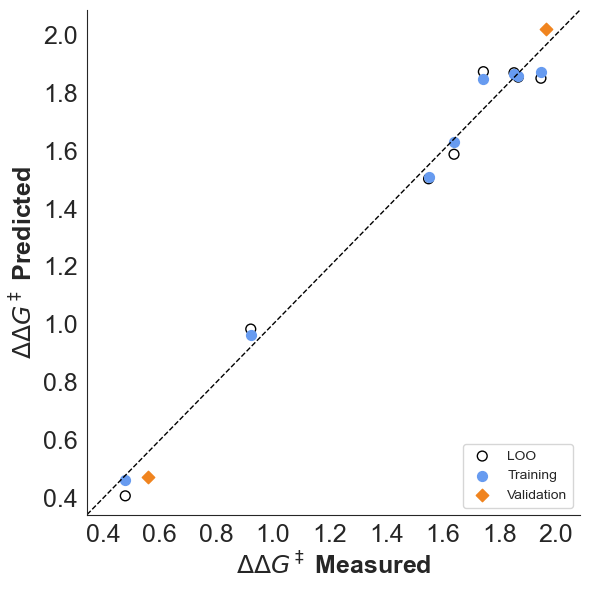

In [84]:
# Bidirectional stepwise selection keeping a set of candidates at each step
n_steps = 2 # This is the maximum number of parameters you want in your models
n_candidates = 50 # This is a measure related to how many models are considered at each step. See mlr_utils.bidirectional_stepwise_regression for more details.
collinearity_cutoff = 0.4 # This is collinearity (r^2) above which parameters won't be included in the same model

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...)
# --------------------------------------------------------------------------------------------------------------

# %notebook inline
plt.ioff()

# This is the function that actually does the MLR model search
results,models,sortedmodels,candidates = mlr_utils.bidirectional_stepwise_regression(modeling_data_df.loc[training_set,:],RESPONSE_LABEL,
                    n_steps=n_steps,n_candidates=n_candidates,collinearity_cutoff=collinearity_cutoff)

#If no validation set is used:
validate = validation_ratio != 0
#if split == 'none': 
    #validation_set = training_set # Set the validation set to the training set so we can still calculate validation R^2

# Set up the validation R^2 and MAE for each model in the results dataframe
for i in results.index:
    model_terms = results.loc[i,"Model"]
    model = models[model_terms].model

    # Set the train MAE for each model
    x_train = modeling_data_df.loc[training_set, model_terms]
    y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
    y_predictions_train = model.predict(x_train)
    results.loc[i, 'MAE'] = metrics.mean_absolute_error(y_train, y_predictions_train)

    # Set the train RMSE for each model
    results.loc[i, 'RMSE'] = np.sqrt(metrics.mean_squared_error(y_train, y_predictions_train))

    # Set validation R^2 for each model
    if validate:
        x_validate = modeling_data_df.loc[validation_set, model_terms]
        y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]
        results.loc[i, 'Validation R^2'] = mlr_utils.get_r2(y_validate, model.predict(x_validate), y_train, validation_R2_method)

    # Set k-fold R^2 for each model: takes a while, so it's commented out by default
    #k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=4, n=10)
    #results.loc[i, 'K-fold R^2'] = statistics.mean(k_fold_scores)

# Identify the best model from the bidirectional_stepwise_regression algorithm
selected_model_terms = results.loc[0, "Model"] # Store a tuple of 'xIDs' for the best model
selected_model = models[selected_model_terms].model # Store the LinearRegression object for that model

# Break up the train/validate data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

# Predict the train and validate sets with the model
y_predictions_train = selected_model.predict(x_train)
if validate:
    y_predictions_validate =  selected_model.predict(x_validate)
else:
    print('No validation set provided. Skipping validation step.')
    y_predictions_validate = None
    
# try:
#     y_predictions_validate =  selected_model.predict(x_validate)
# except ValueError as e:
#     print(f'Error: {e}')
#     print('This cell is not currently equiped to handle modeling without a validation set.')
#     raise mlr_utils.StopExecution

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train,y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=4, n=20)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio} (Training: {len(training_set)}, Validation: {len(validation_set)})")

print(f'\nParameters:\n{selected_model.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{selected_model.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {selected_model.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training RMSE = {np.sqrt(metrics.mean_squared_error(y_train, y_predictions_train)):.3f}')
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

if validate:
    print(f"\nValidation R2      = {mlr_utils.get_r2(y_validate,y_predictions_validate,y_train,validation_R2_method):.3f}")
    print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')
    print(f'Validation RMSE    = {np.sqrt(metrics.mean_squared_error(y_validate,y_predictions_validate)):.3f}')

    # Print an insult if necessary
    train_r2 = selected_model.score(x_train, y_train)
    validation_r2 = selected_model.score(x_validate, y_validate)
    if train_r2 - validation_r2 > 0.35 or train_r2 < 0.4 or validation_r2 < 0.2 or q2 < 0:
        print("\n" + random.choice(insults))
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, output_label=RESPONSE_LABEL, plot_xy=True)

## Model Visualization

### Filter and View Multiple Models

In [87]:
# How many terms do you want in the largest model?
max_terms = 2

# What column to sort by? ('R^2', 'Q^2', 'MAE', 'Validation R^2', 'Custom Sorter')
sort_column = 'Custom Sorter' # This is the column that will be used to sort the results

# How many models do you want to display?
models_to_display = 50

# Only show models containing these features. Set to [] to show all models or a list of parameter names to filter.
include_features = [] # Example features to include in the results

# Should the sort be ascending or descending? (Set True if you're using MAE where lower is better, False otherwise)
ascending = False

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE 'Custom Sorter' CALCULATION in line 21
# --------------------------------------------------------------------------------------------------------------

# Calculate a custom sorter for each model
if validate:
    for i in results.index:

        # Set Custom Sorter function for each model.  This can be changed based on what's important to you.
        custom_sorter = results.loc[i,'R^2'] * results.loc[i,'Q^2'] * results.loc[i,'Validation R^2']

        # Make sure two negative values don't cancel each other out to give a false positive
        if(results.loc[i,'R^2'] <= 0 or results.loc[i,'Q^2'] <= 0 or results.loc[i,'Validation R^2'] <= 0):
            custom_sorter = -abs(custom_sorter)
        results.loc[i,'Custom Sorter'] = custom_sorter

# Sort and filter results
filtered_results = results[results.n_terms <= max_terms] # Filter out models with too many terms

# Filter out models that don't contain the specified features
for feature in include_features: 
    filtered_results = filtered_results[filtered_results['Model'].apply(lambda x: feature in x)]

filtered_results.sort_values(by=[sort_column], ascending=ascending, inplace=True)

pd.set_option('display.width', 1000)
print(filtered_results.head(models_to_display))

                                                 Model  n_terms       R^2       Q^2       MAE      RMSE  Validation R^2  Custom Sorter
0    (Sterimol_B1_C2_C3(Å)_morfeus_max, pyramidaliz...        2  0.989439  0.978968  0.038622  0.050275        0.990637       0.959559
6    (Sterimol_B1_C2_C3(Å)_morfeus_max, pyramidaliz...        2  0.988344  0.965296  0.041830  0.052815        0.997912       0.952053
10   (Sterimol_B1_C2_C3(Å)_morfeus_max, pyramidaliz...        2  0.977958  0.959520  0.059069  0.072631        0.993138       0.931931
13   (Sterimol_B1_C2_C3(Å)_morfeus_max, pyramidaliz...        2  0.977419  0.953791  0.061561  0.073513        0.992566       0.925323
26   (distance_C2_C3(Å)_max, Sterimol_B1_C2_C3(Å)_m...        2  0.967505  0.938293  0.072381  0.088185        0.988032       0.896940
9    (Hirsh_charge_C3_range, Sterimol_B1_C2_C3(Å)_m...        2  0.988602  0.961688  0.044156  0.052228        0.930804       0.884940
28   (Hirsh_atom_dipole_C3_range, Sterimol_B1_C2_C3... 

### Display a Specific Model

Fold 0:
  Train: index=[1 2 3 4 5 6]
  Test:  index=[0 7]
  R^2: -6.433551831019631
Fold 1:
  Train: index=[0 1 2 4 6 7]
  Test:  index=[3 5]
  R^2: -0.8696588831451788
Fold 2:
  Train: index=[0 1 3 4 5 7]
  Test:  index=[2 6]
  R^2: 0.8846016053708472
Fold 3:
  Train: index=[0 2 3 5 6 7]
  Test:  index=[1 4]
  R^2: 0.7728827735794978
Fold 4:
  Train: index=[0 1 3 4 5 6]
  Test:  index=[2 7]
  R^2: 0.7540401360826074
Fold 5:
  Train: index=[0 1 2 3 6 7]
  Test:  index=[4 5]
  R^2: 0.881486632430735
Fold 6:
  Train: index=[2 3 4 5 6 7]
  Test:  index=[0 1]
  R^2: -0.3399351520688827
Fold 7:
  Train: index=[0 1 2 4 5 7]
  Test:  index=[3 6]
  R^2: 0.9806132700698257
Fold 8:
  Train: index=[1 3 4 5 6 7]
  Test:  index=[0 2]
  R^2: 0.23371923838083453
Fold 9:
  Train: index=[0 2 4 5 6 7]
  Test:  index=[1 3]
  R^2: -1.6811625618634563
Fold 10:
  Train: index=[0 1 2 3 5 6]
  Test:  index=[4 7]
  R^2: 0.9354214904613325
Fold 11:
  Train: index=[0 1 2 3 4 7]
  Test:  index=[5 6]
  R^2: 0.9434

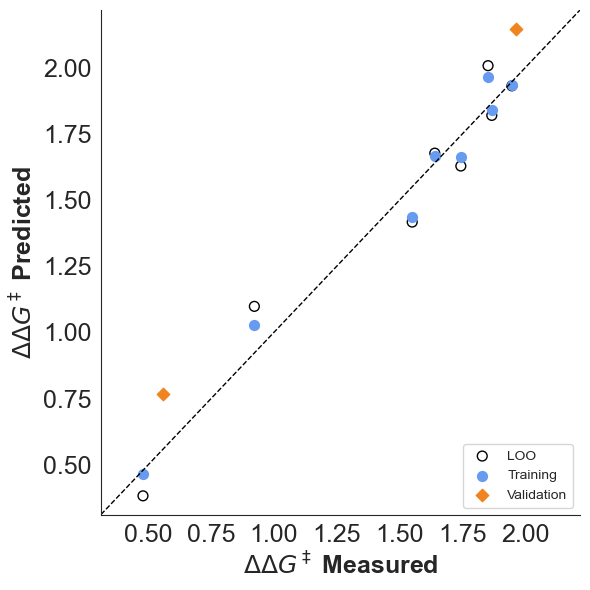

                                OLS Regression Results                               
Dep. Variable:     $\Delta\Delta G^\ddagger$   R-squared:                       0.977
Model:                                   OLS   Adj. R-squared:                  0.967
Method:                        Least Squares   F-statistic:                     105.2
Date:                       Fri, 18 Jul 2025   Prob (F-statistic):           8.21e-05
Time:                               13:54:27   Log-Likelihood:                 9.4197
No. Observations:                          8   AIC:                            -12.84
Df Residuals:                              5   BIC:                            -12.60
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [88]:
# Select model to display
model_index = 18
# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...)
# --------------------------------------------------------------------------------------------------------------

selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model
selected_model = models[selected_model_terms].model # Store the LinearRegression object for that model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

# Predict the train and validate sets with the model
y_predictions_train = selected_model.predict(x_train)
if validate:
    y_predictions_validate =  selected_model.predict(x_validate)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train,y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=4, n=10)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio}")
print(f"\nFeatures: {selected_model_terms}")

print(f'\nParameters:\n{selected_model.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{selected_model.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {selected_model.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training RMSE = {np.sqrt(metrics.mean_squared_error(y_train, y_predictions_train)):.3f}')
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

if validate:
    print(f"\nValidation R2      = {mlr_utils.get_r2(y_validate,y_predictions_validate,y_train,validation_R2_method):.3f}")
    print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')
    print(f'Validation RMSE    = {np.sqrt(metrics.mean_squared_error(y_validate,y_predictions_validate)):.3f}')

    # Print an insult if necessary
    train_r2 = selected_model.score(x_train, y_train)
    validation_r2 = selected_model.score(x_validate, y_validate)
    if train_r2 - validation_r2 > 0.35 or train_r2 < 0.4 or validation_r2 < 0.2 or q2 < 0:
        print("\n"+random.choice(insults))
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, output_label=RESPONSE_LABEL, plot_xy=True)

# Print detailed model statistics
stats_model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
print(stats_model.summary())

## MLR Intertal Test Prediction

If this isn't the final step of your modeling process then this is just another validation set and not a true test set

Fold 0:
  Train: index=[ 0  4  5  6  7  8  9 10 11]
  Test:  index=[1 2 3]
  R^2: 0.6422597660308863
Fold 1:
  Train: index=[ 1  2  3  4  5  7  8  9 10]
  Test:  index=[ 0  6 11]
  R^2: 0.8405044013666212
Fold 2:
  Train: index=[ 0  1  2  3  5  6  8  9 10 11]
  Test:  index=[4 7]
  R^2: 0.8144043532489316
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7 10 11]
  Test:  index=[8 9]
  R^2: 0.9338055374479192
Fold 4:
  Train: index=[ 0  1  2  3  4  6  7  8  9 11]
  Test:  index=[ 5 10]
  R^2: 0.018335256089697105
Fold 5:
  Train: index=[ 2  4  5  6  7  8  9 10 11]
  Test:  index=[0 1 3]
  R^2: 0.49273153818501303
Fold 6:
  Train: index=[ 0  1  3  4  6  8  9 10 11]
  Test:  index=[2 5 7]
  R^2: 0.6205788634382972
Fold 7:
  Train: index=[ 0  1  2  3  5  6  7  8 10 11]
  Test:  index=[4 9]
  R^2: 0.8951124116202605
Fold 8:
  Train: index=[ 0  1  2  3  4  5  6  7  9 10]
  Test:  index=[ 8 11]
  R^2: -0.10565823118354944
Fold 9:
  Train: index=[ 0  1  2  3  4  5  7  8  9 11]
  Test:  index=[ 6 

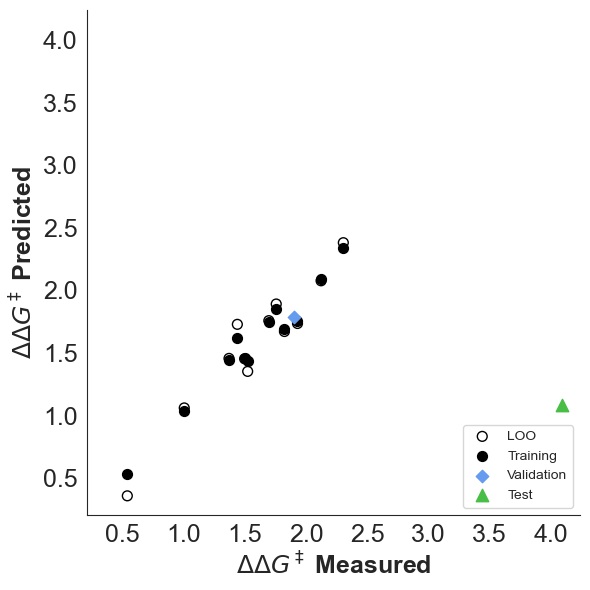

In [88]:
# Select model to test
model_index = 1280

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Select the model to use
selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

x_test = modeling_data_df.loc[test_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the validation set
y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]

# Set up MLR and predict train/validation/test
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
if len(x_validate) > 0: # In case there is no validation set
    y_predictions_validate =  lr.predict(x_validate)
y_predictions_test = lr.predict(x_test)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio}")

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{lr.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

if len(x_validate) > 0: # In case there is no test set
    print(f"\nValidation R2      = {mlr_utils.get_r2(y_validate,y_predictions_validate,y_train,validation_R2_method):.3f}")
    print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')

print(f"\nInternal Test R2      = {mlr_utils.get_r2(y_test,y_predictions_test,y_train,validation_R2_method):.3f}")
print(f'Internal Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
if len(x_validate) > 0: # In case there is no test set
    train_r2 = lr.score(x_train, y_train)
    validate_r2 = lr.score(x_validate, y_validate)
    if train_r2 - validate_r2 > 0.35 or train_r2 < 0.4 or validate_r2 < 0.2 or q2 < 0:
        print("\n" + random.choice(insults))
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, y_predictions_test=y_predictions_test, y_test=y_test, output_label=RESPONSE_LABEL, plot_xy=False)

# Virtual Screening / External Testing

## Import Virtual Screening / External Test Parameter Data

This cell must be executed before any other testing or virtual screening cells

In [ ]:
# This cell assumes that your spreadsheet is in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# vs_parameters_header_rows and vs_parameters_start_col variables.

vs_parameters_file = "kraken descriptors" # Excel file to pull parameters from
vs_parameters_sheet = "DFT_data" # Sheet in the Excel file to pull parameters from
vs_parameters_start_col = 1   # 0-indexed column number where the parameters start
vs_parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
vs_parameters_header_rows = 0 # Number of rows to skip when reading the parameters. First row should be parameter names.

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into a dataframe
vs_parameters_df = pd.read_excel(input_folder + vs_parameters_file + ".xlsx",
                              vs_parameters_sheet,
                              header = vs_parameters_header_rows,
                              index_col = vs_parameters_y_label_col,
                              )

# Skip any columns that are not parameters
vs_parameters_df = vs_parameters_df.iloc[:,vs_parameters_start_col-1:]

# Check that all parameters from the original dataset are present and put them in the same order
try:
  vs_parameters_df = vs_parameters_df[all_features]
except KeyError:
  print('There are features in the main dataset that are not present in this parameter file.')
  print('If your model was built with scaled features, this will cause an error downstream.')

  # If any parameters are missing, at least remove all columns that are not in the original dataset
  columns_to_keep = [col for col in vs_parameters_df.columns if col in all_features]
  vs_parameters_df = vs_parameters_df[columns_to_keep]

# Display the dataframe
display(vs_parameters_df)

## External Test

In [ ]:
# Run this cell before the specific external test cells to set up the external test dataframe
# Read the external test results from the excel sheet
# The final result should be a dataframe with indicies corresponding to the vs_parameters_df from above,
# a column of experimental outputs, and all the relevant parameters

external_test_file = "Multi-Threshold Analysis Data" # Excel file to pull external test results from
external_test_sheet = "Reaction II Validation" # Sheet in the Excel file to pull external test results from
external_test_response_col = 2 # 0-indexed column number for the experimental output
external_test_y_label_col = 0  # 0-indexed column number where the ligand labels are
external_test_header_rows = 0 # Number of rows to skip when reading the responses

############################################################################################################

vs_response_df = pd.read_excel(input_folder + external_test_file + '.xlsx',
                              sheet_name=external_test_sheet,
                              header=external_test_header_rows,
                              index_col=external_test_y_label_col
                              )

# Drop all columns except the experimental output
vs_response_df = vs_response_df.iloc[:, [external_test_response_col-1]]
vs_response_df.columns = [RESPONSE_LABEL]

for column in vs_response_df.columns:
    vs_response_df[column] = pd.to_numeric(vs_response_df[column], errors='coerce')
vs_response_df.dropna(inplace = True)

vs_combined_df = pd.concat([vs_response_df, vs_parameters_df], axis=1, join='inner')

display(vs_combined_df)

### MLR External Test

In [ ]:
# Select model to validate
model_index = 21

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Scales the parameters if scaling was used in the train/test split cell
if use_scaling:
    vs_modeling_data = scaler.transform(vs_combined_df)
    vs_modeling_data_df = pd.DataFrame(vs_modeling_data, index = vs_combined_df.index, columns = vs_combined_df.columns)
    vs_modeling_data_df[RESPONSE_LABEL] = vs_combined_df[RESPONSE_LABEL]
else:
    vs_modeling_data_df = vs_combined_df

# Select the model to use
selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

x_test = vs_modeling_data_df.loc[:, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the validation set
y_test = vs_modeling_data_df.loc[:, RESPONSE_LABEL]

# Set up MLR and predict train/validation/test
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
if len(x_validate) > 0: # In case there is no validation set
    y_predictions_validate =  lr.predict(x_validate)
y_predictions_test = lr.predict(x_test)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio}")

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{lr.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

if len(x_validate) > 0: # In case there is no test set
    print(f"\nValidation R2      = {mlr_utils.get_r2(y_validate,y_predictions_validate,y_train,validation_R2_method):.3f}")
    print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')

print(f"\nExternal Test R2      = {mlr_utils.get_r2(y_test,y_predictions_test,y_train,validation_R2_method):.3f}")
print(f'External Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
if len(x_validate) > 0: # In case there is no test set
    train_r2 = lr.score(x_train, y_train)
    validate_r2 = lr.score(x_validate, y_validate)
    if train_r2 - validate_r2 > 0.35 or train_r2 < 0.4 or validate_r2 < 0.2 or q2 < 0:
        print("\n" + random.choice(insults))
        print('\nAre you sure you want to use this model for external prediction?')
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, y_predictions_test=y_predictions_test, y_test=y_test, output_label=RESPONSE_LABEL, plot_xy=False)

### Threshold External Test

In [ ]:
# Select hotspot to validate
hotspot_index = 0

# Set to True if you want to see only the virtual screen results plotted
hide_training = False

save_evaluation = False # Set to True if you want to save the threshold evaluation to an Excel file in the output_folder
save_filename = "threshold_evaluation" # Name of the Excel file to save the threshold evaluation to if save_evaluation is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN hotspot_utils.plot_hotspot(...)
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]

# Evaluate each validation point on each threshold
threshold_evaluations = hs.expand(vs_combined_df)

# Print the hotspot stats
hs.print_stats()

# Get validation stats and display the hotspot
print("Internal Test Stats:")
hs.get_external_accuracy(vs_combined_df, RESPONSE_LABEL, verbose=True)
hotspot_utils.plot_hotspot(hs, vs_combined_df, vs_parameters_df, coloring='binary', output_label=RESPONSE_LABEL, hide_training=hide_training)

# Display the threshold evaluations
# True means the point is in on the active side of that threshold
display(threshold_evaluations)

# Save the threshold evaluations to an Excel file if requested
if save_evaluation:
    threshold_evaluations.to_excel(output_folder + save_filename + ".xlsx")

## Virtual Screening

### MLR Virtual Screening

In [ ]:
# Predict the outputs for all datapoints in your library read in in the Import Virtaul Screening Data section
# Uses the train/test split defined in the Data Preparation section, so you can reset it there if you want to predict without a split

model_index = 21 # Index of the model you want to predict the validation set with

save_predictions = False # Set to True if you want to save the predictions to an Excel file in the output_folder
save_filename = "mlr_predictions" # Name of the Excel file to save the predictions to if save_predictions is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Scales the parameters if scaling was used in the train/test split cell
if use_scaling:
    dummy_column = pd.DataFrame({RESPONSE_LABEL: [0] * len(vs_parameters_df)}, index=vs_parameters_df.index)
    vs_modeling_data = pd.concat([dummy_column, vs_parameters_df], axis=1)
    final_index = vs_modeling_data.index
    final_columns = vs_modeling_data.columns
    vs_modeling_data = scaler.transform(vs_modeling_data)
    vs_modeling_data_df = pd.DataFrame(vs_modeling_data, index = final_index, columns = final_columns)
else:
    vs_modeling_data_df = vs_combined_df

# Select the model to use
selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_validate = modeling_data_df.loc[validation_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_validate = modeling_data_df.loc[validation_set, RESPONSE_LABEL]

x_vs = vs_modeling_data_df.loc[:, selected_model_terms] # Dataframe containing just the parameters used in this model for all ligands in the library

# Set up MLR and predict train/test
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
y_predictions_validate =  lr.predict(x_validate)
y_predictions_vs = lr.predict(x_vs)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Validation ratio: {validation_ratio}")

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{lr.coef_[i]:10.4f} * {parameter}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nValidation R2      = {mlr_utils.external_r2(y_validate,y_predictions_validate,y_train):.3f}")
print(f'Validation MAE     = {metrics.mean_absolute_error(y_validate,y_predictions_validate):.3f}')

# Print an insult if necessary
train_r2 = lr.score(x_train, y_train)
validate_r2 = lr.score(x_validate, y_validate)
if train_r2 - validate_r2 > 0.35 or train_r2 < 0.4 or validate_r2 < 0.2 or q2 < 0:
    print("\n" + random.choice(insults))
    
# Plot the model
print('\nVIRTUAL SCREEN POINTS HAVE NOT BEEN EXPERIMENTALLY TESTED. THIS VISUALIZATION IS ONLY TO SHOW DISTRIBUTION OF PREDICTIONS.')
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_validate, y_predictions_validate, loo_train, y_predictions_test=y_predictions_vs, output_label=RESPONSE_LABEL)

if save_predictions:
    validation_predictions_df = pd.DataFrame(y_predictions_vs, index=x_vs.index, columns=['Predicted ' + RESPONSE_LABEL])
    validation_predictions_df.to_excel(output_folder + save_filename + ".xlsx")

### Threshold Virtual Screening

In [ ]:
# Select hotspot to screen against
hotspot_index = 0

# Set to True if you want to see only the virtual screen results plotted
hide_training = False

save_predictions = False # Set to True if you want to save the predictions to an Excel file in the output_folder
save_filename = "Threshold_VS_Predictions" # Name of the Excel file to save the predictions to if save_predictions is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]

# Trim down to the parameter values relevant to this hotspot and add binary evaluations from each ligand
# True in an xID column indicates that the ligand is predicted to be active by that threshold
virtual_screen_report_df = vs_parameters_df.loc[:, hs.threshold_features]
# virtual_screen_report_df.columns = [f'{parameter}' for parameter in virtual_screen_report_df.columns]

threshold_evaluations = hs.expand(vs_parameters_df)
threshold_evaluations.columns = [f'{parameter} Active' for parameter in threshold_evaluations.columns]
virtual_screen_report_df = pd.concat([virtual_screen_report_df, threshold_evaluations], axis=1)

# Create a column for the final hotspot evaluation if there is more than a single threshold
if len(hs.thresholds) > 1:
    for ligand in virtual_screen_report_df.index:
        evaluation = all([virtual_screen_report_df.loc[ligand, f'{threshold} Active'] for threshold in hs.threshold_features])
        virtual_screen_report_df.loc[ligand, 'Full Hotspot Evaluation'] = evaluation

display(virtual_screen_report_df)

print('The plot below is meant only to show the distribution of the virtual screen since experimental data has not been supplied')
hotspot_utils.plot_hotspot(hs, vs_parameters=vs_parameters_df, hide_training=hide_training, coloring='binary', output_label=RESPONSE_LABEL, gradient_color='Oranges')

# Save the predictions to an Excel file if requested
if save_predictions:
    virtual_screen_report_df.to_excel(output_folder + save_filename + ".xlsx")